In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

1 Physical GPUs, 1 Logical GPU


In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [3]:
import numpy as np

# Specify the path to your dataset
full_data_path = "/content/drive/MyDrive/KaggleData/ProcessedData/full_data.npy"

# Load the dataset
full_data = np.load(full_data_path, allow_pickle=True)

# Verify the data is loaded correctly
print(f"Loaded dataset size: {full_data.shape}")

Loaded dataset size: (7909, 2)


# PRE-PROCESSING

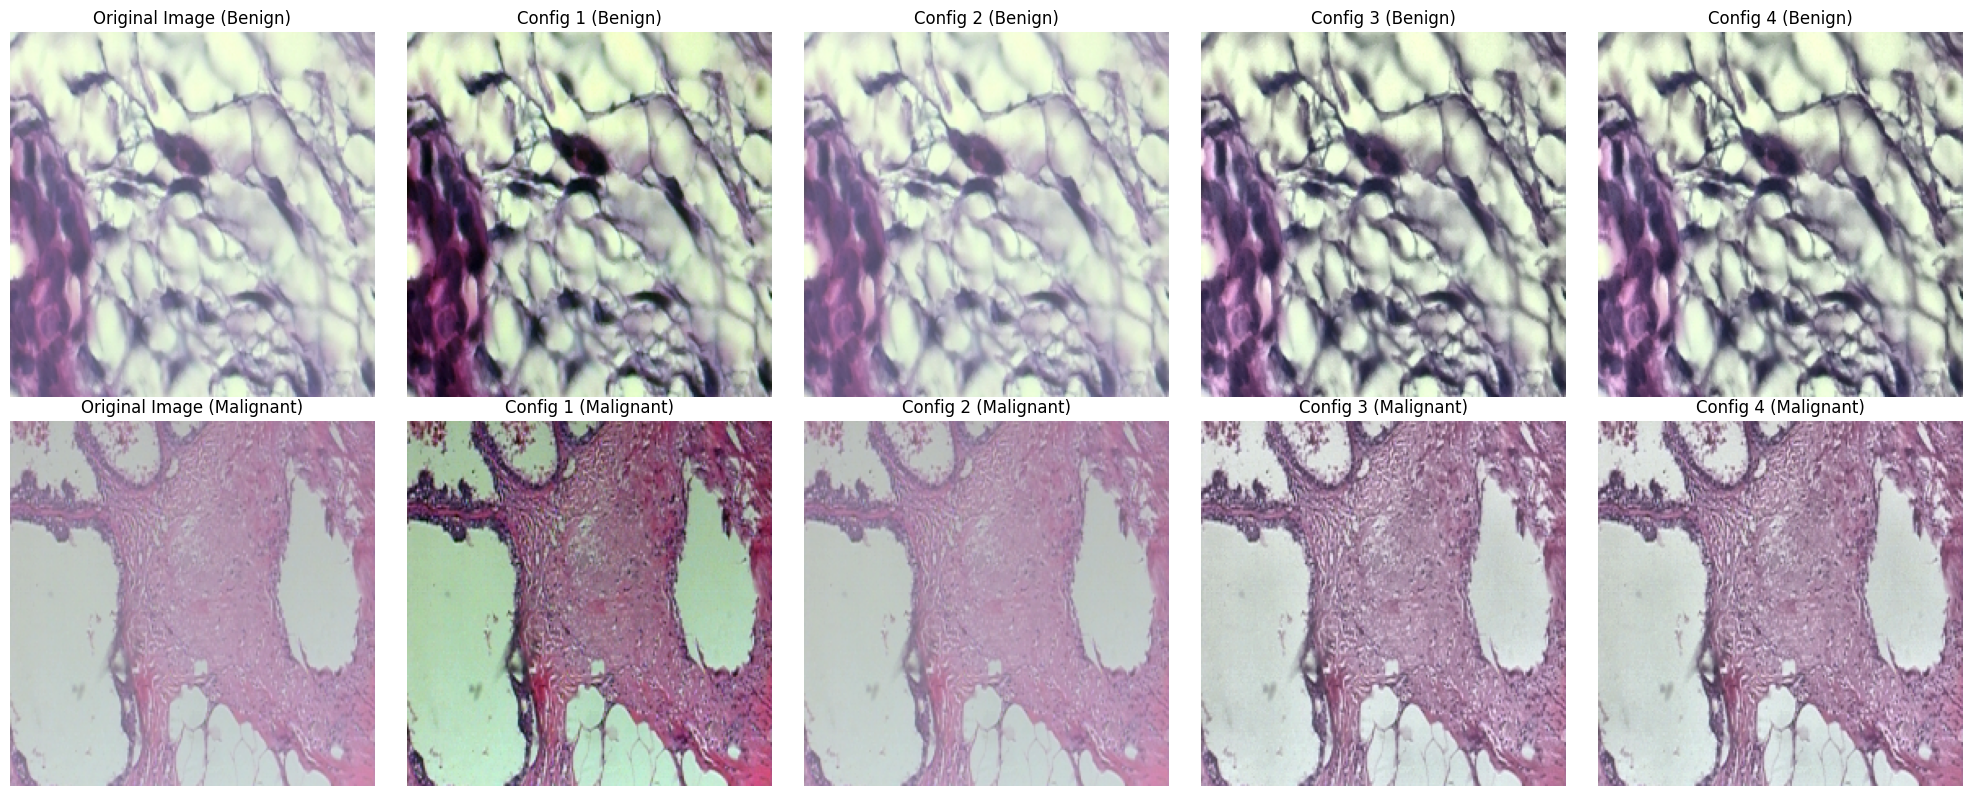

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2

base_path = "/content/drive/MyDrive/KaggleData/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/"

subcategories = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

# Function to find a random image within specified subcategories
def find_random_image(base_path, category, subcategories):
    sub = random.choice(subcategories[category])
    sub_path = os.path.join(base_path, category, 'SOB', sub)
    case_folder = random.choice(os.listdir(sub_path))
    case_path = os.path.join(sub_path, case_folder)
    mag_folder = random.choice(os.listdir(case_path))
    mag_path = os.path.join(case_path, mag_folder)
    image_name = random.choice([file for file in os.listdir(mag_path) if file.endswith('.png')])
    return os.path.join(mag_path, image_name)

# Function to apply various configurations of augmentation
def augment_image(image_path, config_num):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    if config_num == 1:
        # Channel Normalization
        for i in range(3):
            channel = img[:, :, i]
            channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
            img[:, :, i] = (channel * 255).astype(np.uint8)

    elif config_num == 2:
        # Color Deconvolution (placeholder)
        pass

    elif config_num == 3 or config_num == 4:
        # CLAHE Enhancement on LAB color space
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    return img

# Function to display original and augmented images
def display_original_and_augmented_images(image_path_dict):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (label, image_path) in enumerate(image_path_dict.items()):
        # Display the original image
        original_img = cv2.imread(image_path)
        original_img = cv2.resize(original_img, (224, 224))
        axes[i*5].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[i*5].set_title(f'Original Image ({label})')
        axes[i*5].axis('off')

        # Display augmented images for each configuration
        for config_num in range(1, 5):
            augmented_img = augment_image(image_path, config_num)
            axes[i*5 + config_num].imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
            axes[i*5 + config_num].set_title(f'Config {config_num} ({label})')
            axes[i*5 + config_num].axis('off')

    plt.tight_layout()
    plt.show()

# Randomly select one benign and one malignant image
benign_image = find_random_image(base_path, 'benign', subcategories)
malignant_image = find_random_image(base_path, 'malignant', subcategories)

display_original_and_augmented_images({'Benign': benign_image, 'Malignant': malignant_image})


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

base_path = "/content/drive/MyDrive/KaggleData/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/"

subcategories = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

def find_random_image(base_path, category, subcategories):
    sub = random.choice(subcategories[category])
    sub_path = os.path.join(base_path, category, 'SOB', sub)
    case_folder = random.choice(os.listdir(sub_path))
    case_path = os.path.join(sub_path, case_folder)
    mag_folder = random.choice(os.listdir(case_path))  # Choosing a random magnification folder
    mag_path = os.path.join(case_path, mag_folder)
    image_name = random.choice([file for file in os.listdir(mag_path) if file.endswith('.png')])
    return os.path.join(mag_path, image_name)


    # Example Data Augmentation Visualization
def display_augmented_images(image_path_dict):
    datagen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    #     rotation_range=40,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode='nearest'
    # )

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (label, image_path) in enumerate(image_path_dict.items()):
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize image to match model input
        img_array = np.array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        axes[i*5].imshow(img)
        axes[i*5].set_title(f'Original Image ({label})')
        axes[i*5].axis('off')

        j = 1
        for batch in datagen.flow(img_array, batch_size=1):
            axes[i*5 + j].imshow(batch[0].astype('uint8'))
            axes[i*5 + j].set_title(f'Augmented {j} ({label})')
            axes[i*5 + j].axis('off')
            j += 1
            if j > 4:
                break

    plt.tight_layout()
    plt.show()

# Randomly select one benign and one malignant image
benign_image = find_random_image(base_path, 'benign', subcategories)
malignant_image = find_random_image(base_path, 'malignant', subcategories)

display_augmented_images({'Benign': benign_image, 'Malignant': malignant_image})

Output hidden; open in https://colab.research.google.com to view.

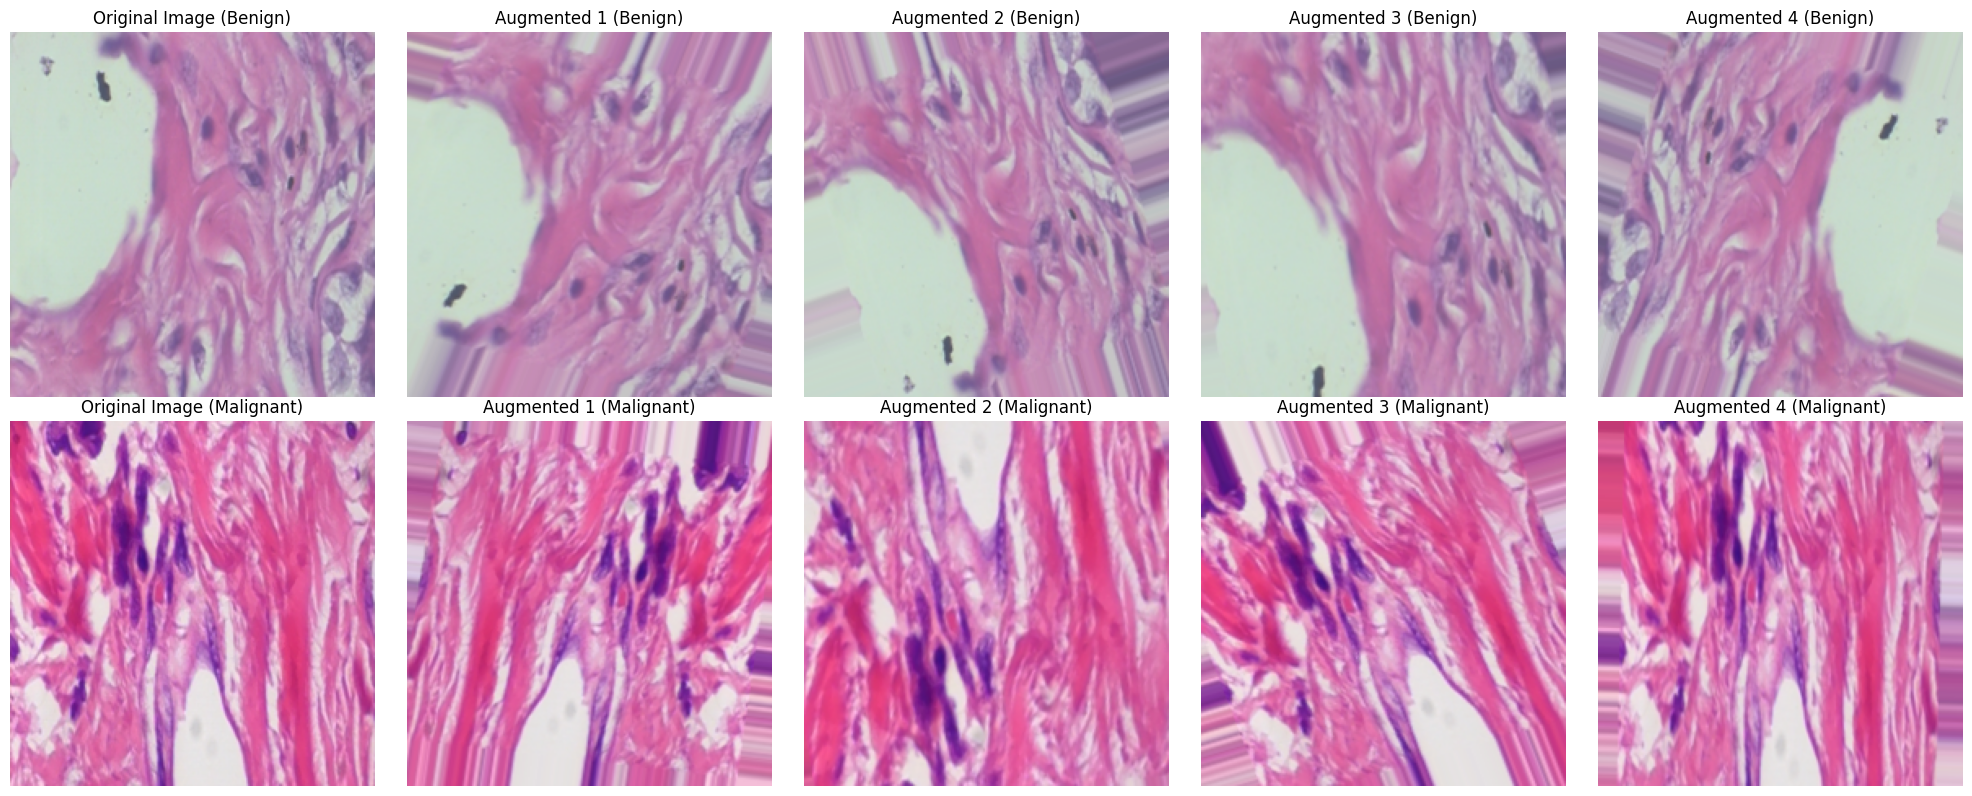

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

base_path = "/content/drive/MyDrive/KaggleData/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/"

subcategories = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

def find_random_image(base_path, category, subcategories):
    sub = random.choice(subcategories[category])
    sub_path = os.path.join(base_path, category, 'SOB', sub)
    case_folder = random.choice(os.listdir(sub_path))
    case_path = os.path.join(sub_path, case_folder)
    mag_folder = random.choice(os.listdir(case_path))  # Choosing a random magnification folder
    mag_path = os.path.join(case_path, mag_folder)
    image_name = random.choice([file for file in os.listdir(mag_path) if file.endswith('.png')])
    return os.path.join(mag_path, image_name)


    # Example Data Augmentation Visualization
def display_augmented_images(image_path_dict):
    datagen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    #     rotation_range=40,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     fill_mode='nearest'
    # )

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (label, image_path) in enumerate(image_path_dict.items()):
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize image to match model input
        img_array = np.array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        axes[i*5].imshow(img)
        axes[i*5].set_title(f'Original Image ({label})')
        axes[i*5].axis('off')

        j = 1
        for batch in datagen.flow(img_array, batch_size=1):
            axes[i*5 + j].imshow(batch[0].astype('uint8'))
            axes[i*5 + j].set_title(f'Augmented {j} ({label})')
            axes[i*5 + j].axis('off')
            j += 1
            if j > 4:
                break

    plt.tight_layout()
    plt.show()

# Randomly select one benign and one malignant image
benign_image = find_random_image(base_path, 'benign', subcategories)
malignant_image = find_random_image(base_path, 'malignant', subcategories)

display_augmented_images({'Benign': benign_image, 'Malignant': malignant_image})

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

base_path = "/content/drive/MyDrive/KaggleData/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/"

subcategories = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

def find_random_image(base_path, category, subcategories):
    sub = random.choice(subcategories[category])
    sub_path = os.path.join(base_path, category, 'SOB', sub)
    case_folder = random.choice(os.listdir(sub_path))
    case_path = os.path.join(sub_path, case_folder)
    mag_folder = random.choice(os.listdir(case_path))  # Choosing a random magnification folder
    mag_path = os.path.join(case_path, mag_folder)
    image_name = random.choice([file for file in os.listdir(mag_path) if file.endswith('.png')])
    return os.path.join(mag_path, image_name)



def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    This version keeps all color information.
    """
    img = img.astype(np.float32) / 255.0  # Normalize the image

    # Define stain vectors for Hematoxylin (H) and Eosin (E)
    H = np.array([0.65, 0.70, 0.29])
    E = np.array([0.07, 0.99, 0.11])

    # Perform color deconvolution
    stain_matrix_HE = np.array([H, E]).T
    conv_matrix = np.linalg.inv(stain_matrix_HE)
    stain_deconvolved = np.dot(img.reshape(-1, 3), conv_matrix).reshape(img.shape[0], img.shape[1], 2)

    # Normalize stain intensities
    stain_deconvolved -= np.min(stain_deconvolved, axis=(0, 1))
    stain_deconvolved /= np.max(stain_deconvolved, axis=(0, 1))

    # Recombine the stains into a single image
    img_recombined = np.dot(stain_deconvolved, stain_matrix_HE.T)
    img_recombined = np.clip(img_recombined, 0, 1)

    # Convert to 8-bit image
    img_recombined = (img_recombined * 255).astype(np.uint8)

    return img_recombined

def preprocess_image(img):
    """
    Resize and normalize staining of the input image.
    """
    img = cv2.resize(img, (224, 224))  # Resize the image
    img_normalized = normalize_staining(img)
    return img_normalized


# Data augmentation generator with preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
# Randomly select one benign and one malignant image
benign_image = find_random_image(base_path, 'benign', subcategories)
malignant_image = find_random_image(base_path, 'malignant', subcategories)

display_augmented_images({'Benign': benign_image, 'Malignant': malignant_image})


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

base_path = "/content/drive/MyDrive/KaggleData/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/"

subcategories = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

def find_random_image(base_path, category, subcategories):
    sub = random.choice(subcategories[category])
    sub_path = os.path.join(base_path, category, 'SOB', sub)
    case_folder = random.choice(os.listdir(sub_path))
    case_path = os.path.join(sub_path, case_folder)
    mag_folder = random.choice(os.listdir(case_path))  # Choosing a random magnification folder
    mag_path = os.path.join(case_path, mag_folder)
    image_name = random.choice([file for file in os.listdir(mag_path) if file.endswith('.png')])
    return os.path.join(mag_path, image_name)



def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    Using pseudo-inverse for solving color deconvolution.
    """
    img = img.astype(np.float32) / 255  # Normalize the image

    # Define stain vectors
    H = np.array([0.65, 0.70, 0.29])
    E = np.array([0.07, 0.99, 0.11])

    # Create matrix of stain vectors
    HE = np.array([H, E]).T

    # Calculate pseudo-inverse of HE matrix
    pseudo_inv_HE = np.linalg.pinv(HE.T)  # Ensuring the pseudo-inverse is compatible for multiplication

    # Perform color deconvolution
    Y = np.dot(img.reshape(-1, 3), pseudo_inv_HE).reshape(img.shape[0], img.shape[1], -1)

    # Normalize stains to 0-1 range
    Y = (Y - np.min(Y, axis=(0, 1))) / (np.max(Y, axis=(0, 1)) - np.min(Y, axis=(0, 1)))

    # Use only the Hematoxylin channel for the output
    recreated_img = Y[:, :, 0]  # Assuming Hematoxylin is the first channel after transformation
    recreated_img = np.clip(recreated_img, 0, 1)
    recreated_img = (recreated_img * 255).astype(np.uint8)  # Scale back to 0-255 range
    return np.stack([recreated_img] * 3, axis=-1)  # Stack to create a 3-channel image

def preprocess_image(img):
    img = np.array(img)  # Convert PIL image to numpy array
    img = cv2.resize(img, (224, 224))  # Resize the image
    img = normalize_staining(img)      # Normalize the staining
    return img




# Data augmentation generator with preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
# Randomly select one benign and one malignant image
benign_image = find_random_image(base_path, 'benign', subcategories)
malignant_image = find_random_image(base_path, 'malignant', subcategories)

display_augmented_images({'Benign': benign_image, 'Malignant': malignant_image})


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming full_data is structured as a list of [image, label]
images = np.array([i[0] for i in full_data])  # Extract images
labels = np.array([i[1] for i in full_data])  # Extract labels

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# No need to convert labels to categorical for binary classification with sigmoid output

# Further split your training set into training and validation sets if needed
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
# Custom weighted binary cross-entropy function
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    # Explicitly cast y_true to float
    y_true_float = tf.cast(y_true, tf.float32)

    # Calculate binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)

    # Calculate the weight vector
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative

    # Apply weights to the binary crossentropy
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

# Class weights for imbalanced data
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}


**NORMALISE 1**

In [ ]:
# Define normalize_staining and preprocess_image functions
# Define normalize_staining and preprocess_image functions
def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    Simplified normalization that retains the color information.
    """
    # Convert to float and scale pixels to the range [0, 1]
    img = img.astype(np.float32) / 255.0

    # Normalize by channel
    for i in range(3):  # Assuming img is a 3-channel image
        channel = img[:, :, i]
        channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
        img[:, :, i] = channel

    # Convert back to 8-bit
    img = (img * 255).astype(np.uint8)
    return img

def preprocess_image(img):
    """
    Resize and normalize staining of the input image.
    """
    img = cv2.resize(img, (224, 224))  # Resize the image
    img_normalized = normalize_staining(img)
    return img_normalized

**OUR MODEL 4**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import os
import pickle

def preprocess_image(img):
    """
    Resize, normalize staining, and apply CLAHE to the input image.
    """
    img = cv2.resize(img, (224, 224))
    img_normalized = normalize_staining(img)

    # Convert to LAB color space (CLAHE works best on the lightness channel)
    img_lab = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2LAB)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])

    # Convert back to BGR
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    return img_clahe

# Custom weighted binary cross-entropy function
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    # Explicitly cast y_true to float
    y_true_float = tf.cast(y_true, tf.float32)

    # Calculate binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)

    # Calculate the weight vector
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative

    # Apply weights to the binary crossentropy
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

# Build model function with binary classification adjustments
def build_model():
    model = Sequential()
    backbone = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.add(backbone)
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    return model



# Train the model with CLAHE preprocessing
def train_model(model_function, train_dataset, val_dataset, epochs, model_save_dir, class_weights):
    model = model_function()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: weighted_binary_crossentropy(
                      y_true, y_pred,
                      weight_positive=class_weights[1],
                      weight_negative=class_weights[0]),
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)

    # Data augmentation generator with CLAHE-based preprocessing
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    history = model.fit(
        train_dataset[0], train_dataset[1],
        epochs=epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=[early_stop, rlrp]
    )

    # Save model and training history
    model_path = os.path.join(model_save_dir, "dense_clahe1.h5")
    model.save(model_path)
    history_path = os.path.join(model_save_dir, "dense_clahe1_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model and training history saved to {model_save_dir}")

    return model, history



# Calculate class weights (no changes needed)
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}

# Train model with CLAHE
model_save_dir = "/content/drive/MyDrive/KaggleData/Predictions"
model, history = train_model(build_model, (x_train, y_train), (x_val, y_val), 12, model_save_dir, class_weights)

# Evaluation (no changes needed)
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

Epoch 1/12
159/159 [==============================] - 183s 579ms/step - loss: 0.6276 - accuracy: 0.7668 - val_loss: 0.2520 - val_accuracy: 0.9036 - lr: 1.0000e-04
Epoch 2/12
159/159 [==============================] - 90s 565ms/step - loss: 0.2122 - accuracy: 0.9204 - val_loss: 0.1818 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 3/12
159/159 [==============================] - 90s 564ms/step - loss: 0.1082 - accuracy: 0.9638 - val_loss: 0.1387 - val_accuracy: 0.9502 - lr: 1.0000e-04
Epoch 4/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0858 - accuracy: 0.9698 - val_loss: 0.1000 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 5/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0401 - accuracy: 0.9891 - val_loss: 0.0999 - val_accuracy: 0.9692 - lr: 1.0000e-04
Epoch 6/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0279 - accuracy: 0.9919 - val_loss: 0.1160 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 7/12
159/159 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and training history saved to /content/drive/MyDrive/KaggleData/Predictions
40/40 [==============================] - 6s 140ms/step - loss: 0.0610 - accuracy: 0.9755
Validation Loss: 0.06097566336393356, Validation Accuracy: 0.9755133986473083


In [ ]:
# Save model and training history
model_path = os.path.join(model_save_dir, "dense_clahe1.h5")  # Add the custom name here
model.save(model_path)

history_path = os.path.join(model_save_dir, "dense_clahe1_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"Dynamic custom model and training history saved to {model_save_dir}")

Dynamic custom model and training history saved to /content/drive/MyDrive/KaggleData/Predictions


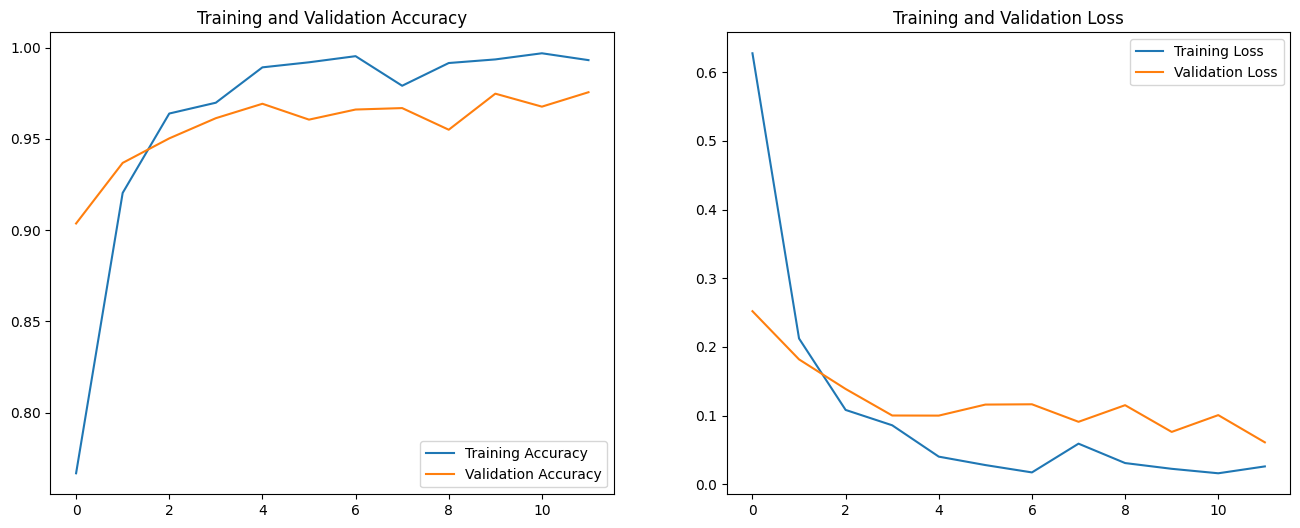

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Generate predicted probabilities from the model
predicted_probabilities = model.predict(x_val).ravel()  # Ensure it's a 1D array

# Prepare y_val as a binary 1D array if it's not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()

# Get predicted probabilities for the validation set
y_val_probs = model.predict(x_val)

# Assuming binary classification and using sigmoid output, you may want to flatten the probabilities if necessary
y_val_probs = y_val_probs.flatten()

40/40 [==============================] - 5s 137ms/step


Optimal threshold: 0.4
Optimal F1 Score:  0.9844380403458213


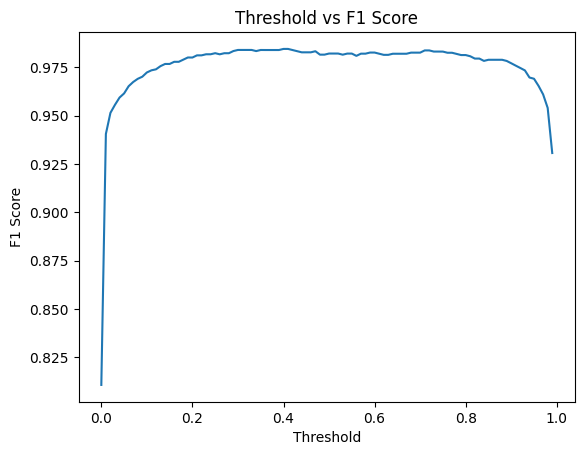

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predicted_probabilities' contains the predicted probabilities for the validation set

def calculate_f1_scores(probabilities, true_labels):
    """Calculates F1 scores for a range of thresholds."""
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(true_labels, (probabilities > threshold).astype(int)) for threshold in thresholds]
    return thresholds, f1_scores

def find_optimal_threshold(probabilities, true_labels):
    """Finds the threshold that yields the highest F1 score."""
    thresholds, f1_scores = calculate_f1_scores(probabilities, true_labels)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_scores[optimal_idx]  # Return the F1 score as well

# Example usage:

optimal_threshold, optimal_f1_score = find_optimal_threshold(predicted_probabilities, y_val)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal F1 Score:  {optimal_f1_score}")

# Plotting (unchanged from your original code)
thresholds, f1_scores = calculate_f1_scores(predicted_probabilities, y_val)
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.show()

40/40 [==============================] - 5s 139ms/step
Accuracy: 0.9755134281200631
Precision: 0.9814814814814815
Recall: 0.9826187717265353
Specificity: 0.9602977667493796
F1-score: 0.9820497973364215
ROC-AUC: 0.9973374661073237


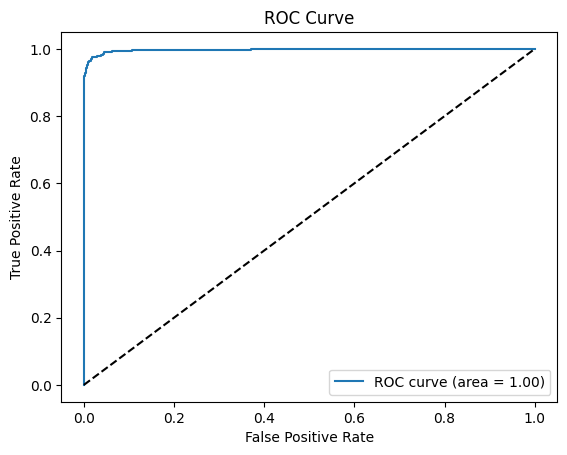

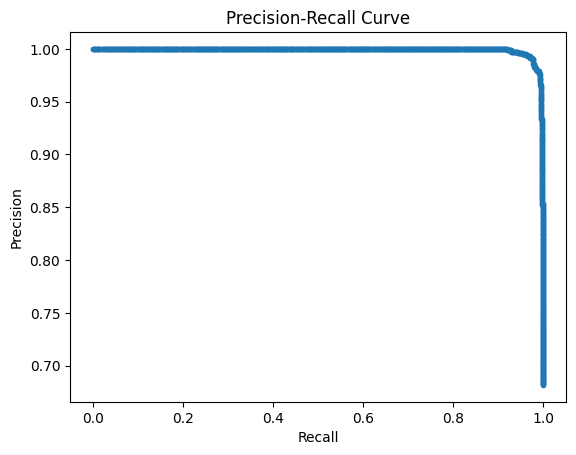

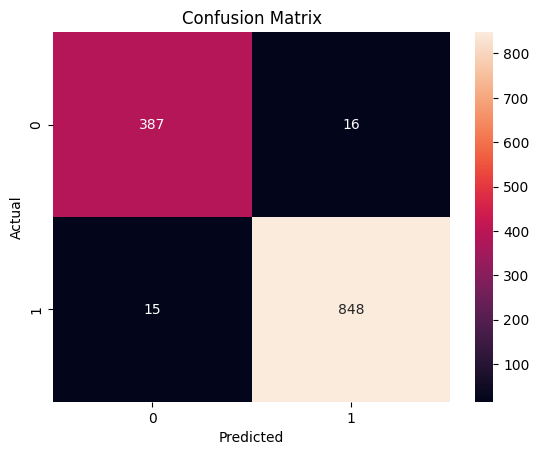

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf


# Generate predictions
y_pred_prob = model.predict(x_val)
y_pred = np.round(y_pred_prob)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn+fp)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

50/50 [==============================] - 7s 140ms/step
Brier Score: 0.3117
50/50 [==============================] - 7s 140ms/step
ECE: 0.0132
MCE: 0.2165


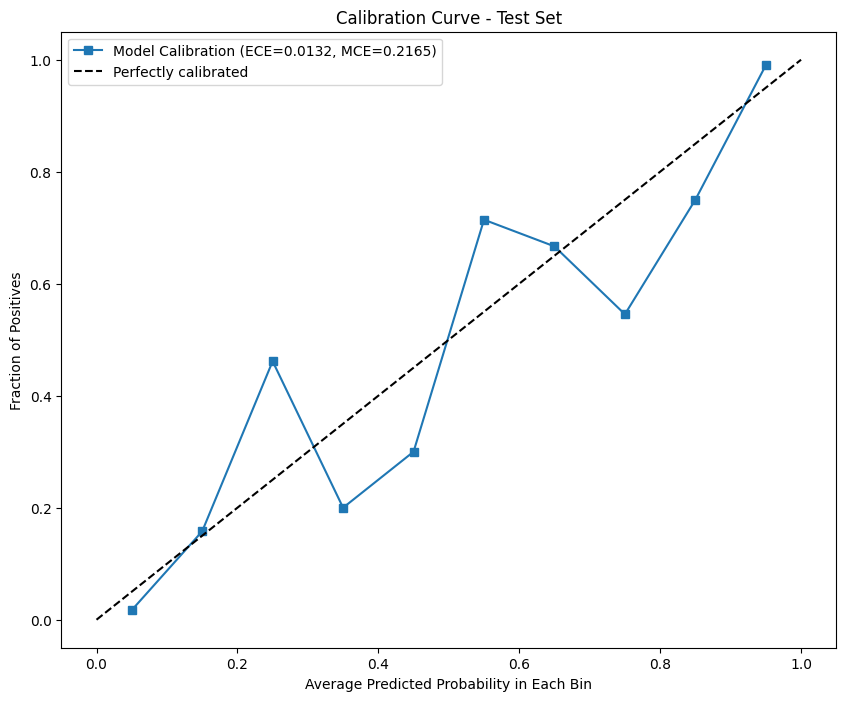

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.32).astype(int)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss

# Convert binary predictions back to probabilities for class 1
y_pred_probs_binary = y_pred_binary * y_pred_probs + (1 - y_pred_binary) * (1 - y_pred_probs)

# Brier score
brier = brier_score_loss(Y_test, y_pred_probs_binary)
print(f'Brier Score: {brier:.4f}')


import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test data
# Get predicted probabilities for the validation or test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities from your model

# Actual test labels should be in 'Y_test'
# Ensure these are 1D arrays
y_pred_probs = y_pred_probs.flatten()
Y_test = Y_test.flatten()

n_bins = 10
bin_width = 1.0 / n_bins
bin_edges = np.linspace(0, 1, n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_counts = np.histogram(y_pred_probs, bins=bin_edges)[0]
bin_correct = np.histogram(y_pred_probs[Y_test == 1], bins=bin_edges)[0]
bin_scores = np.histogram(y_pred_probs, bins=bin_edges, weights=y_pred_probs)[0]

# Avoid division by zero
bin_accuracies = np.where(bin_counts > 0, bin_correct / bin_counts, 0)
bin_confidences = np.where(bin_counts > 0, bin_scores / bin_counts, 0)

ece = np.sum((np.abs(bin_accuracies - bin_confidences) * bin_counts) / Y_test.size)
mce = np.max(np.abs(bin_accuracies - bin_confidences))

print(f'ECE: {ece:.4f}')
print(f'MCE: {mce:.4f}')

# Plot the calibration curve
# Calibration plot
plt.figure(figsize=(10, 8))
plt.plot(bin_centers, bin_accuracies, 's-', label=f'Model Calibration (ECE={ece:.4f}, MCE={mce:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.title('Calibration Curve - Test Set')
plt.xlabel('Average Predicted Probability in Each Bin')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.4).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

50/50 [==============================] - 7s 139ms/step
Log Loss: 0.0908


50/50 [==============================] - 7s 138ms/step
Original - Brier score loss: 0.0241, Log Loss: 0.0908
Platt - Brier score loss: 0.0260, Log Loss: 0.1076
Isotonic - Brier score loss: 0.0245, Log Loss: 0.1361


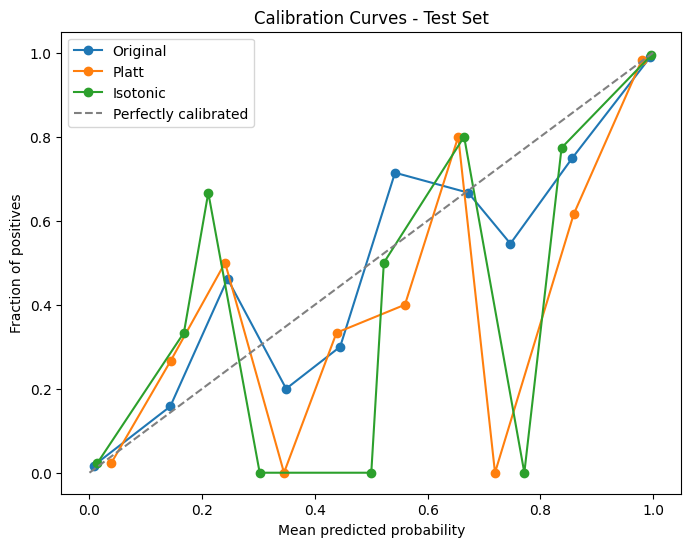

In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate predicted probabilities for both validation and test sets
val_probs = model.predict(x_val).ravel()
test_probs = model.predict(X_test).ravel()

# Prepare binary arrays if not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()
y_test_binary = np.argmax(Y_test, axis=1) if Y_test.ndim > 1 else Y_test.flatten()

# Fit Platt Scaling on validation probabilities
platt_scaler = LogisticRegression(solver='liblinear')
platt_scaler.fit(val_probs.reshape(-1, 1), y_val_binary)

# Apply Platt scaling to test set probabilities
calibrated_probs_platt = platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1]

# Fit and apply Isotonic Regression for calibration on validation probabilities
isotonic_scaler = IsotonicRegression(out_of_bounds='clip')
isotonic_scaler.fit(val_probs, y_val_binary)

# Apply Isotonic Regression to test set probabilities
calibrated_probs_isotonic = isotonic_scaler.transform(test_probs)

# Calculate the original and calibrated Brier score loss and log loss for test set
metrics = {
    'Original': test_probs,
    'Platt': calibrated_probs_platt,
    'Isotonic': calibrated_probs_isotonic
}

for label, probs in metrics.items():
    brier = brier_score_loss(y_test_binary, probs)
    logloss = log_loss(y_test_binary, probs)
    print(f"{label} - Brier score loss: {brier:.4f}, Log Loss: {logloss:.4f}")

# Plot calibration curves for the test set
plt.figure(figsize=(8, 6))
for label, probs in metrics.items():
    prob_true, prob_pred = calibration_curve(y_test_binary, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=label)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves - Test Set')
plt.legend()
plt.show()

50/50 [==============================] - 7s 138ms/step


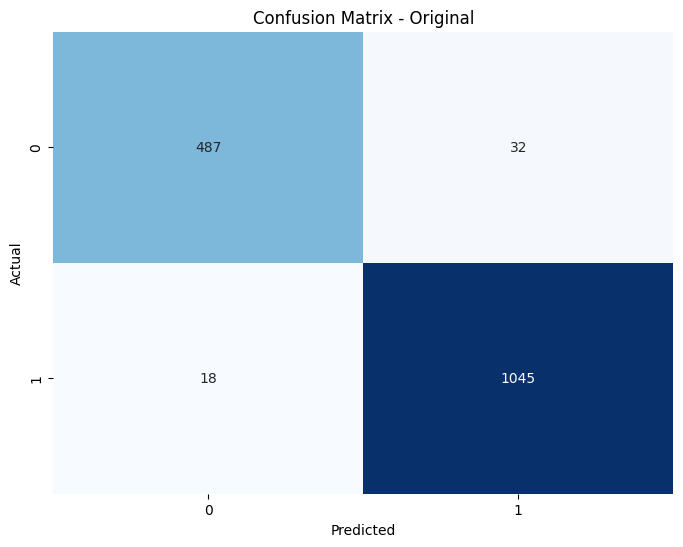

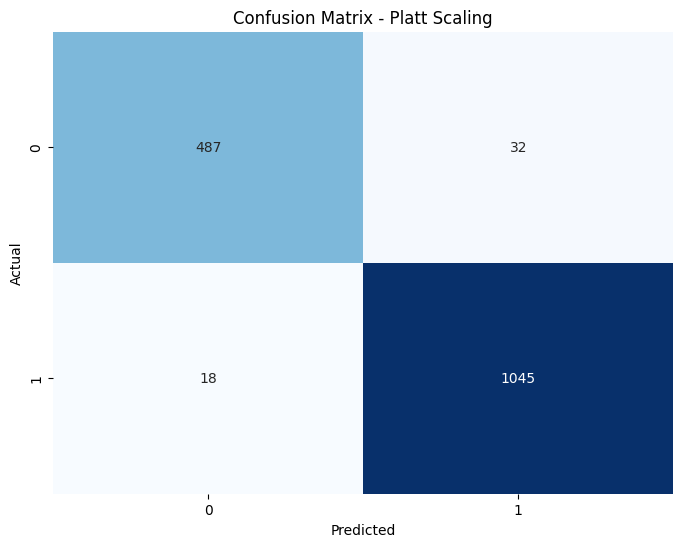

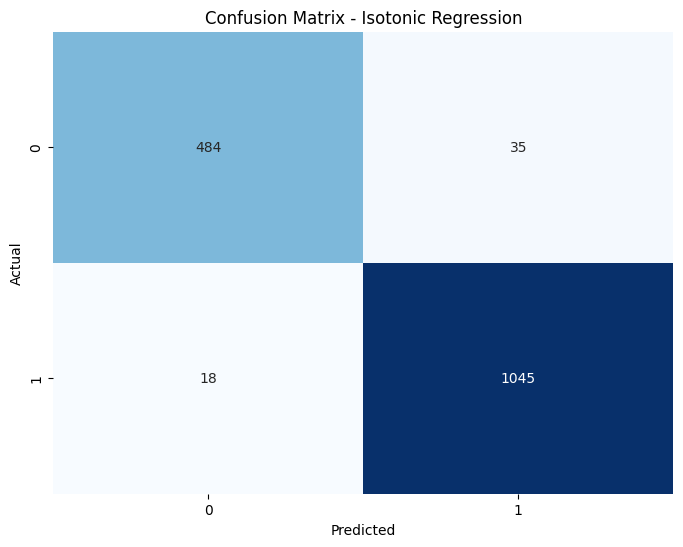

Classification Report - Original:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       519
           1       0.97      0.98      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.96      0.96      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Platt Scaling:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       519
           1       0.97      0.98      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.96      0.96      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Isotonic Regression:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       519
           1       0.97      0.98      0.98      1063

    accuracy                           0.97      1582
   macro a

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set using your trained model
predicted_probabilities_test = model.predict(X_test).ravel()

# Assuming you have already defined calibrated_probs_platt and calibrated_probs_isotonic using the test set probabilities
# If not, you would need to generate these using the calibration models trained on the validation set probabilities.

# Choose a threshold for classification
threshold = 0.4  # Adjust this threshold to suit your application

# Convert the calibrated probabilities to class predictions based on the chosen threshold
predicted_classes_original = (predicted_probabilities_test >= threshold).astype(int)
predicted_classes_platt = (calibrated_probs_platt >= threshold).astype(int)
predicted_classes_isotonic = (calibrated_probs_isotonic >= threshold).astype(int)

# Compute confusion matrices for the original and calibrated probabilities
cm_original = confusion_matrix(y_test_binary, predicted_classes_original)
cm_platt = confusion_matrix(y_test_binary, predicted_classes_platt)
cm_isotonic = confusion_matrix(y_test_binary, predicted_classes_isotonic)

# Define a function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot the confusion matrices
plot_confusion_matrix(cm_original, 'Confusion Matrix - Original')
plot_confusion_matrix(cm_platt, 'Confusion Matrix - Platt Scaling')
plot_confusion_matrix(cm_isotonic, 'Confusion Matrix - Isotonic Regression')

# Print out the classification report for each
print('Classification Report - Original:')
print(classification_report(y_test_binary, predicted_classes_original))

print('Classification Report - Platt Scaling:')
print(classification_report(y_test_binary, predicted_classes_platt))

print('Classification Report - Isotonic Regression:')
print(classification_report(y_test_binary, predicted_classes_isotonic))

**THIS IS OUR MODEL 1**

In [ ]:

# Custom weighted binary cross-entropy function
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    # Explicitly cast y_true to float
    y_true_float = tf.cast(y_true, tf.float32)

    # Calculate binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)

    # Calculate the weight vector
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative

    # Apply weights to the binary crossentropy
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import os
import pickle


# Define normalize_staining and preprocess_image functions
def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    Simplified normalization that retains the color information.
    """
    # Convert to float and scale pixels to the range [0, 1]
    img = img.astype(np.float32) / 255.0

    # Normalize by channel
    for i in range(3):  # Assuming img is a 3-channel image
        channel = img[:, :, i]
        channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
        img[:, :, i] = channel

    # Convert back to 8-bit
    img = (img * 255).astype(np.uint8)
    return img

def preprocess_image(img):
    """
    Resize and normalize staining of the input image.
    """
    img = cv2.resize(img, (224, 224))  # Resize the image
    img_normalized = normalize_staining(img)
    return img_normalized


# Build model function with binary classification adjustments
def build_model():
    model = Sequential()
    backbone = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.add(backbone)
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    return model



# Train the model without dynamic alpha
def train_model(model_function, train_dataset, val_dataset, epochs, model_save_dir, class_weights):
    model = model_function()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: weighted_binary_crossentropy(
                      y_true, y_pred,
                      weight_positive=class_weights[1],
                      weight_negative=class_weights[0]),
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)

    # Data augmentation generator with preprocessing function
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'# rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)
    history = model.fit(
        train_dataset[0], train_dataset[1],
        epochs=epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=[early_stop, rlrp]
    )

    # Save model and training history
    model_path = os.path.join(model_save_dir, "dense_model2.h5")
    model.save(model_path)
    history_path = os.path.join(model_save_dir, "dense_model2_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model and training history saved to {model_save_dir}")

    return model, history

# Prepare datasets for training
# Assuming x_train, y_train, x_val, y_val are defined and preprocessed

# Class weights for imbalanced data
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}

# Train the model without dynamic alpha
model_save_dir = "/content/drive/MyDrive/KaggleData/Predictions"
model, history = train_model(build_model, (x_train, y_train), (x_val, y_val), 12, model_save_dir, class_weights)

# Now you can safely evaluate the model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

Epoch 1/12
159/159 [==============================] - 183s 574ms/step - loss: 0.5539 - accuracy: 0.7896 - val_loss: 0.3817 - val_accuracy: 0.8404 - lr: 1.0000e-04
Epoch 2/12
159/159 [==============================] - 90s 567ms/step - loss: 0.1673 - accuracy: 0.9384 - val_loss: 0.1635 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 3/12
159/159 [==============================] - 90s 566ms/step - loss: 0.0903 - accuracy: 0.9680 - val_loss: 0.1148 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 4/12
159/159 [==============================] - 90s 565ms/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 0.1831 - val_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 5/12
159/159 [==============================] - 90s 565ms/step - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.1179 - val_accuracy: 0.9589 - lr: 1.0000e-04
Epoch 6/12
159/159 [==============================] - 90s 566ms/step - loss: 0.0253 - accuracy: 0.9937 - val_loss: 0.1214 - val_accuracy: 0.9637 - lr: 1.0000e-04
Epoch 7/12
159/159 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and training history saved to /content/drive/MyDrive/KaggleData/Predictions
40/40 [==============================] - 6s 140ms/step - loss: 0.0799 - accuracy: 0.9747
Validation Loss: 0.07987038791179657, Validation Accuracy: 0.9747235178947449


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import os
import pickle


# Define normalize_staining and preprocess_image functions
def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    Simplified normalization that retains the color information.
    """
    # Convert to float and scale pixels to the range [0, 1]
    img = img.astype(np.float32) / 255.0

    # Normalize by channel
    for i in range(3):  # Assuming img is a 3-channel image
        channel = img[:, :, i]
        channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
        img[:, :, i] = channel

    # Convert back to 8-bit
    img = (img * 255).astype(np.uint8)
    return img

def preprocess_image(img):
    """
    Resize and normalize staining of the input image.
    """
    img = cv2.resize(img, (224, 224))  # Resize the image
    img_normalized = normalize_staining(img)
    return img_normalized


# Build model function with binary classification adjustments
def build_model():
    model = Sequential()
    backbone = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.add(backbone)
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    return model



# Train the model without dynamic alpha
def train_model(model_function, train_dataset, val_dataset, epochs, model_save_dir, class_weights):
    model = model_function()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: weighted_binary_crossentropy(
                      y_true, y_pred,
                      weight_positive=class_weights[1],
                      weight_negative=class_weights[0]),
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)

    # Data augmentation generator with preprocessing function
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'# rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)
    history = model.fit(
        train_dataset[0], train_dataset[1],
        epochs=epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=[early_stop, rlrp]
    )

    # Save model and training history
    model_path = os.path.join(model_save_dir, "dense_model2.h5")
    model.save(model_path)
    history_path = os.path.join(model_save_dir, "dense_model2_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model and training history saved to {model_save_dir}")

    return model, history

# Prepare datasets for training
# Assuming x_train, y_train, x_val, y_val are defined and preprocessed

# Class weights for imbalanced data
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}

# Train the model without dynamic alpha
model_save_dir = "/content/drive/MyDrive/KaggleData/Predictions"
model, history = train_model(build_model, (x_train, y_train), (x_val, y_val), 12, model_save_dir, class_weights)

# Now you can safely evaluate the model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

Epoch 1/12
159/159 [==============================] - 200s 673ms/step - loss: 0.6116 - accuracy: 0.7629 - val_loss: 0.3010 - val_accuracy: 0.8689 - lr: 1.0000e-04
Epoch 2/12
159/159 [==============================] - 90s 564ms/step - loss: 0.1995 - accuracy: 0.9231 - val_loss: 0.1684 - val_accuracy: 0.9344 - lr: 1.0000e-04
Epoch 3/12
159/159 [==============================] - 90s 563ms/step - loss: 0.0907 - accuracy: 0.9708 - val_loss: 0.1277 - val_accuracy: 0.9487 - lr: 1.0000e-04
Epoch 4/12
159/159 [==============================] - 90s 563ms/step - loss: 0.0505 - accuracy: 0.9842 - val_loss: 0.1189 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 5/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.1036 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 6/12
159/159 [==============================] - 90s 563ms/step - loss: 0.0212 - accuracy: 0.9951 - val_loss: 0.1208 - val_accuracy: 0.9629 - lr: 1.0000e-04
Epoch 7/12
159/159 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and training history saved to /content/drive/MyDrive/KaggleData/Predictions
40/40 [==============================] - 6s 140ms/step - loss: 0.0731 - accuracy: 0.9716
Validation Loss: 0.07308664172887802, Validation Accuracy: 0.971563994884491


In [ ]:
# Save model and training history
model_path = os.path.join(model_save_dir, "dense_model2.h5")  # Add the custom name here
model.save(model_path)

history_path = os.path.join(model_save_dir, "dense_model2_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"Dynamic custom model and training history saved to {model_save_dir}")

Dynamic custom model and training history saved to /content/drive/MyDrive/KaggleData/Predictions


In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.32).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

50/50 [==============================] - 10s 138ms/step
Log Loss: 0.0975


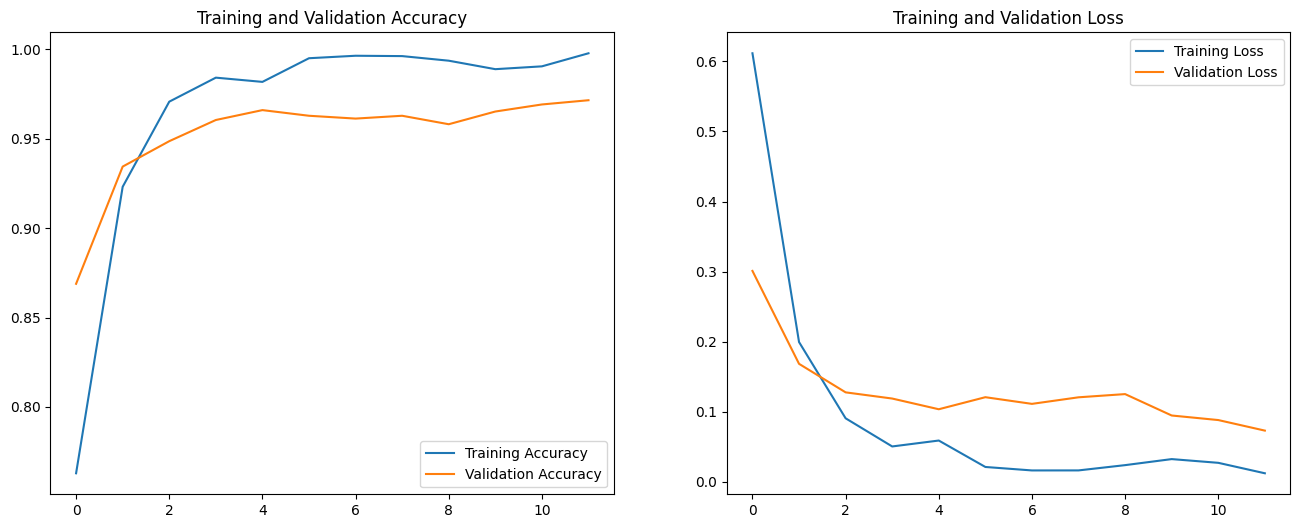

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Generate predicted probabilities from the model
predicted_probabilities = model.predict(x_val).ravel()  # Ensure it's a 1D array

# Prepare y_val as a binary 1D array if it's not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()

# Get predicted probabilities for the validation set
y_val_probs = model.predict(x_val)

# Assuming binary classification and using sigmoid output, you may want to flatten the probabilities if necessary
y_val_probs = y_val_probs.flatten()

40/40 [==============================] - 5s 138ms/step


Optimal threshold: 0.32
Optimal F1 Score:  0.9821736630247269


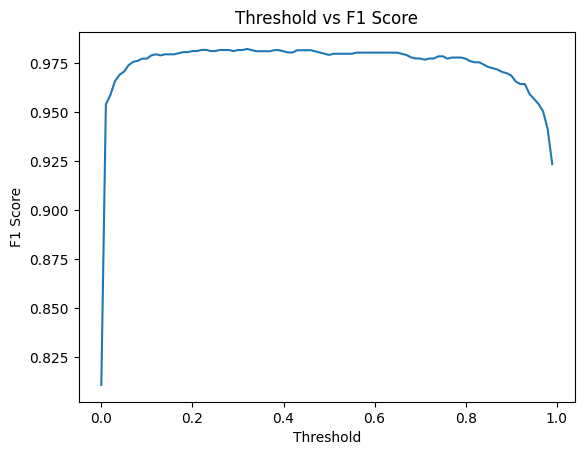

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predicted_probabilities' contains the predicted probabilities for the validation set

def calculate_f1_scores(probabilities, true_labels):
    """Calculates F1 scores for a range of thresholds."""
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(true_labels, (probabilities > threshold).astype(int)) for threshold in thresholds]
    return thresholds, f1_scores

def find_optimal_threshold(probabilities, true_labels):
    """Finds the threshold that yields the highest F1 score."""
    thresholds, f1_scores = calculate_f1_scores(probabilities, true_labels)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_scores[optimal_idx]  # Return the F1 score as well

# Example usage:

optimal_threshold, optimal_f1_score = find_optimal_threshold(predicted_probabilities, y_val)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal F1 Score:  {optimal_f1_score}")

# Plotting (unchanged from your original code)
thresholds, f1_scores = calculate_f1_scores(predicted_probabilities, y_val)
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.show()


40/40 [==============================] - 5s 139ms/step
Accuracy: 0.9715639810426541
Precision: 0.9791425260718424
Recall: 0.9791425260718424
Specificity: 0.9553349875930521
F1-score: 0.9791425260718424
ROC-AUC: 0.9964748741334545


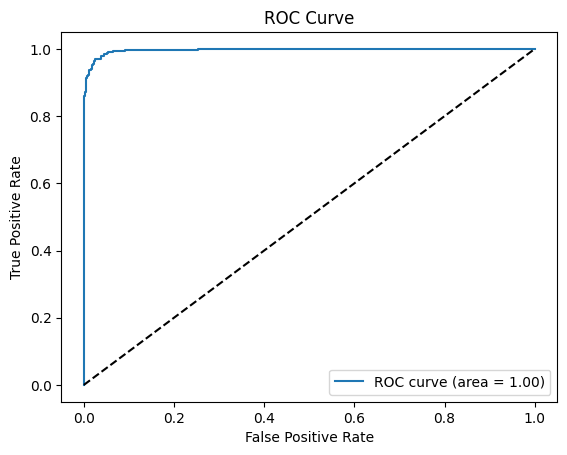

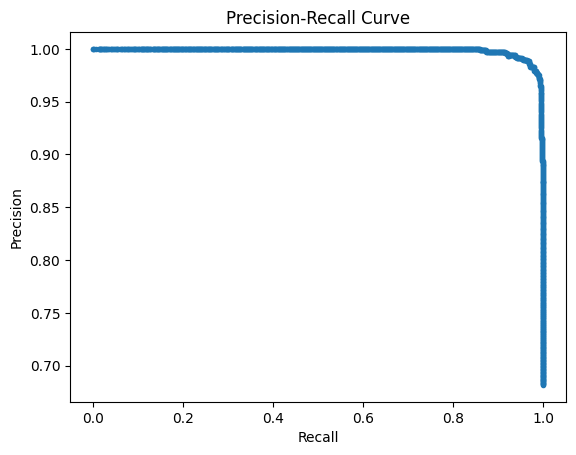

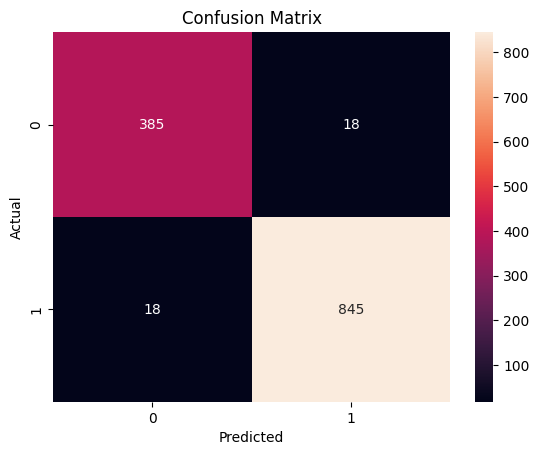

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf


# Generate predictions
y_pred_prob = model.predict(x_val)
y_pred = np.round(y_pred_prob)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn+fp)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.32).astype(int)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss

# Convert binary predictions back to probabilities for class 1
y_pred_probs_binary = y_pred_binary * y_pred_probs + (1 - y_pred_binary) * (1 - y_pred_probs)

# Brier score
brier = brier_score_loss(Y_test, y_pred_probs_binary)
print(f'Brier Score: {brier:.4f}')

50/50 [==============================] - 7s 140ms/step
Brier Score: 0.3171


50/50 [==============================] - 7s 138ms/step
ECE: 0.0218
MCE: 0.3166


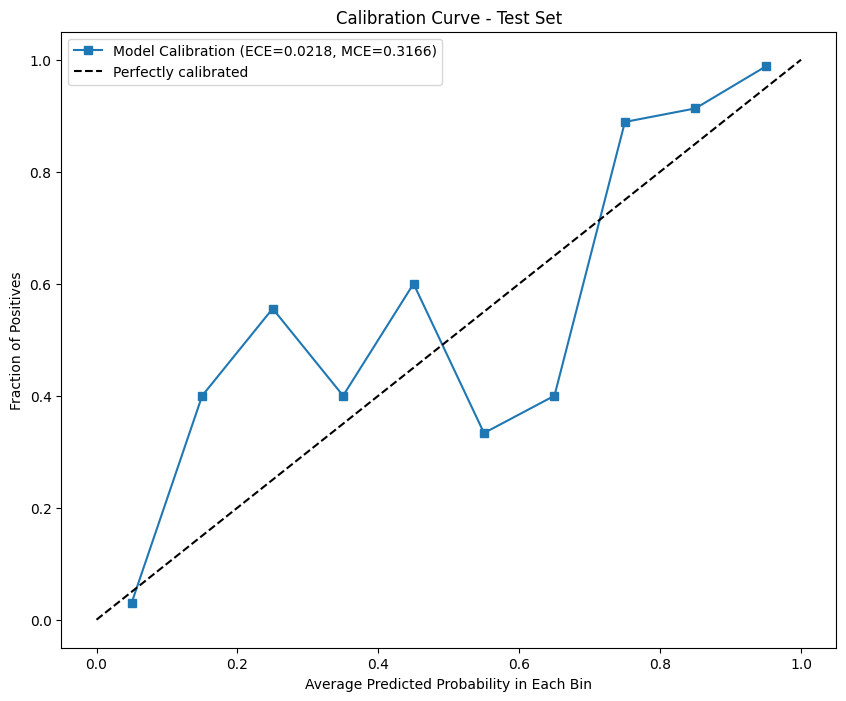

In [ ]:



import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test data
# Get predicted probabilities for the validation or test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities from your model

# Actual test labels should be in 'Y_test'
# Ensure these are 1D arrays
y_pred_probs = y_pred_probs.flatten()
Y_test = Y_test.flatten()

n_bins = 10
bin_width = 1.0 / n_bins
bin_edges = np.linspace(0, 1, n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_counts = np.histogram(y_pred_probs, bins=bin_edges)[0]
bin_correct = np.histogram(y_pred_probs[Y_test == 1], bins=bin_edges)[0]
bin_scores = np.histogram(y_pred_probs, bins=bin_edges, weights=y_pred_probs)[0]

# Avoid division by zero
bin_accuracies = np.where(bin_counts > 0, bin_correct / bin_counts, 0)
bin_confidences = np.where(bin_counts > 0, bin_scores / bin_counts, 0)

ece = np.sum((np.abs(bin_accuracies - bin_confidences) * bin_counts) / Y_test.size)
mce = np.max(np.abs(bin_accuracies - bin_confidences))

print(f'ECE: {ece:.4f}')
print(f'MCE: {mce:.4f}')

# Plot the calibration curve
# Calibration plot
plt.figure(figsize=(10, 8))
plt.plot(bin_centers, bin_accuracies, 's-', label=f'Model Calibration (ECE={ece:.4f}, MCE={mce:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.title('Calibration Curve - Test Set')
plt.xlabel('Average Predicted Probability in Each Bin')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

50/50 [==============================] - 7s 138ms/step
Log Loss: 0.1113
50/50 [==============================] - 7s 139ms/step
Original - Brier score loss: 0.0282, Log Loss: 0.1113
Platt - Brier score loss: 0.0294, Log Loss: 0.1206
Isotonic - Brier score loss: 0.0277, Log Loss: 0.1250


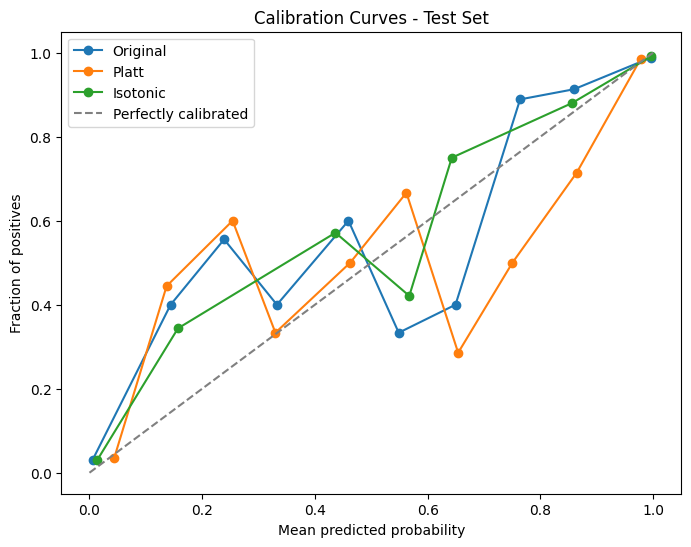

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.49).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate predicted probabilities for both validation and test sets
val_probs = model.predict(x_val).ravel()
test_probs = model.predict(X_test).ravel()

# Prepare binary arrays if not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()
y_test_binary = np.argmax(Y_test, axis=1) if Y_test.ndim > 1 else Y_test.flatten()

# Fit Platt Scaling on validation probabilities
platt_scaler = LogisticRegression(solver='liblinear')
platt_scaler.fit(val_probs.reshape(-1, 1), y_val_binary)

# Apply Platt scaling to test set probabilities
calibrated_probs_platt = platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1]

# Fit and apply Isotonic Regression for calibration on validation probabilities
isotonic_scaler = IsotonicRegression(out_of_bounds='clip')
isotonic_scaler.fit(val_probs, y_val_binary)

# Apply Isotonic Regression to test set probabilities
calibrated_probs_isotonic = isotonic_scaler.transform(test_probs)

# Calculate the original and calibrated Brier score loss and log loss for test set
metrics = {
    'Original': test_probs,
    'Platt': calibrated_probs_platt,
    'Isotonic': calibrated_probs_isotonic
}

for label, probs in metrics.items():
    brier = brier_score_loss(y_test_binary, probs)
    logloss = log_loss(y_test_binary, probs)
    print(f"{label} - Brier score loss: {brier:.4f}, Log Loss: {logloss:.4f}")

# Plot calibration curves for the test set
plt.figure(figsize=(8, 6))
for label, probs in metrics.items():
    prob_true, prob_pred = calibration_curve(y_test_binary, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=label)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves - Test Set')
plt.legend()
plt.show()

50/50 [==============================] - 7s 138ms/step


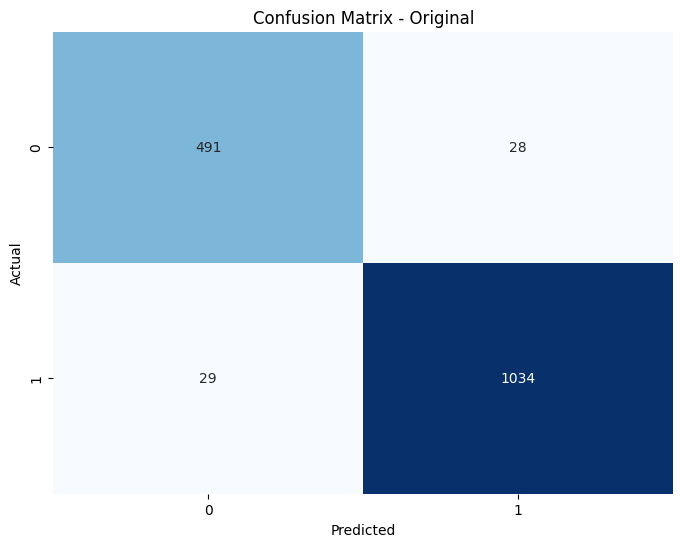

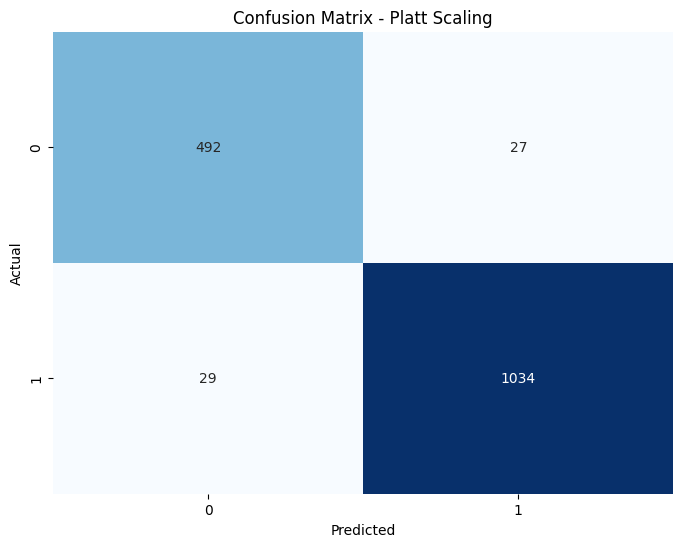

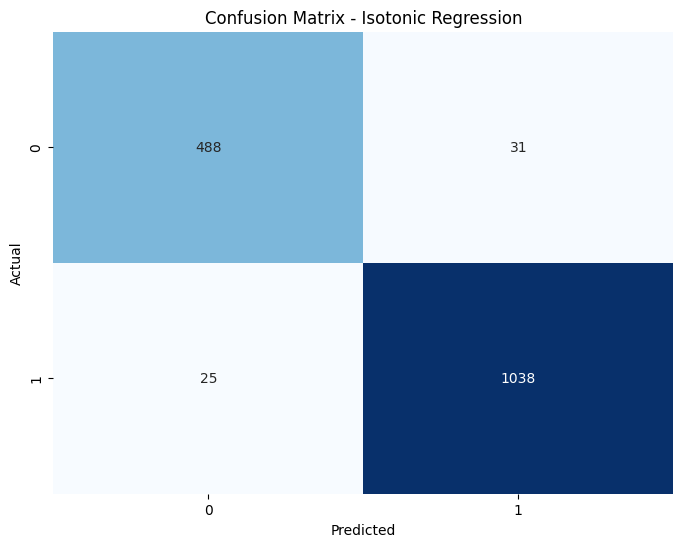

Classification Report - Original:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       519
           1       0.97      0.97      0.97      1063

    accuracy                           0.96      1582
   macro avg       0.96      0.96      0.96      1582
weighted avg       0.96      0.96      0.96      1582

Classification Report - Platt Scaling:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       519
           1       0.97      0.97      0.97      1063

    accuracy                           0.96      1582
   macro avg       0.96      0.96      0.96      1582
weighted avg       0.96      0.96      0.96      1582

Classification Report - Isotonic Regression:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       519
           1       0.97      0.98      0.97      1063

    accuracy                           0.96      1582
   macro a

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set using your trained model
predicted_probabilities_test = model.predict(X_test).ravel()

# Assuming you have already defined calibrated_probs_platt and calibrated_probs_isotonic using the test set probabilities
# If not, you would need to generate these using the calibration models trained on the validation set probabilities.

# Choose a threshold for classification
threshold = 0.32  # Adjust this threshold to suit your application

# Convert the calibrated probabilities to class predictions based on the chosen threshold
predicted_classes_original = (predicted_probabilities_test >= threshold).astype(int)
predicted_classes_platt = (calibrated_probs_platt >= threshold).astype(int)
predicted_classes_isotonic = (calibrated_probs_isotonic >= threshold).astype(int)

# Compute confusion matrices for the original and calibrated probabilities
cm_original = confusion_matrix(y_test_binary, predicted_classes_original)
cm_platt = confusion_matrix(y_test_binary, predicted_classes_platt)
cm_isotonic = confusion_matrix(y_test_binary, predicted_classes_isotonic)

# Define a function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot the confusion matrices
plot_confusion_matrix(cm_original, 'Confusion Matrix - Original')
plot_confusion_matrix(cm_platt, 'Confusion Matrix - Platt Scaling')
plot_confusion_matrix(cm_isotonic, 'Confusion Matrix - Isotonic Regression')

# Print out the classification report for each
print('Classification Report - Original:')
print(classification_report(y_test_binary, predicted_classes_original))

print('Classification Report - Platt Scaling:')
print(classification_report(y_test_binary, predicted_classes_platt))

print('Classification Report - Isotonic Regression:')
print(classification_report(y_test_binary, predicted_classes_isotonic))

**OUR MODEL 2**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import os
import pickle

# Define normalize_staining and preprocess_image functions

def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    """
    # Convert to float and divide by 255
    img = img.astype(np.float32) / 255

    # Define stain vectors (from Ruifrok AC and Johnston DA)
    # Hematoxylin + Eosin
    H = np.array([0.65, 0.70, 0.29])
    E = np.array([0.07, 0.99, 0.11])
    # Create orthogonal matrix
    HE = np.array([H, E]).T

    # Perform color deconvolution
    Y = np.linalg.solve(HE, img.reshape(-1, 3).T).T

    # Normalize stains to 0-1 range
    Y = (Y - np.min(Y, axis=0)) / (np.max(Y, axis=0) - np.min(Y, axis=0))

    # Recreate the image using only the Hematoxylin channel
    recreated_img = np.clip(Y[:, 0] * H, 0, 1)
    recreated_img = (recreated_img.reshape(img.shape[0], img.shape[1], 3) * 255).astype(np.uint8)

    return recreated_img

def preprocess_image(img):
    # Resize the image to square dimensions (e.g., 224x224)
    resized_img = cv2.resize(img, (224, 224))
    # Normalize the staining (assuming this is your normalization function)
    normalized_img = normalize_staining(resized_img)
    return normalized_img

# Custom weighted binary cross-entropy function
# Custom weighted binary cross-entropy function
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    # Explicitly cast y_true to float
    y_true_float = tf.cast(y_true, tf.float32)

    # Calculate binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)

    # Calculate the weight vector
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative

    # Apply weights to the binary crossentropy
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

# Build model function with binary classification adjustments
def build_model():
    model = Sequential()
    backbone = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.add(backbone)
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    return model



# Train the model without dynamic alpha
def train_model(model_function, train_dataset, val_dataset, epochs, model_save_dir, class_weights):
    model = model_function()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: weighted_binary_crossentropy(
                      y_true, y_pred,
                      weight_positive=class_weights[1],
                      weight_negative=class_weights[0]),
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)

    # Data augmentation generator with preprocessing function
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'# rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)
    history = model.fit(
        train_dataset[0], train_dataset[1],
        epochs=epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=[early_stop, rlrp]
    )

    # Save model and training history
    model_path = os.path.join(model_save_dir, "dense_model1.h5")
    model.save(model_path)
    history_path = os.path.join(model_save_dir, "dense_model1_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model and training history saved to {model_save_dir}")

    return model, history

# Prepare datasets for training
# Assuming x_train, y_train, x_val, y_val are defined and preprocessed

# Class weights for imbalanced data
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}

# Train the model without dynamic alpha
model_save_dir = "/content/drive/MyDrive/KaggleData/Predictions"
model, history = train_model(build_model, (x_train, y_train), (x_val, y_val), 12, model_save_dir, class_weights)

# Now you can safely evaluate the model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/12
159/159 [==============================] - 233s 655ms/step - loss: 0.5703 - accuracy: 0.7661 - val_loss: 0.6679 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/12
159/159 [==============================] - 89s 560ms/step - loss: 0.1671 - accuracy: 0.9399 - val_loss: 0.2344 - val_accuracy: 0.9076 - lr: 1.0000e-04
Epoch 3/12
159/159 [==============================] - 90s 568ms/step - loss: 0.0753 - accuracy: 0.9763 - val_loss: 0.1436 - val_accuracy: 0.9455 - lr: 1.0000e-04
Epoch 4/12
159/159 [==============================] - 91s 572ms/step - loss: 0.0497 - accuracy: 0.9838 - val_loss: 0.1164 - val_accuracy: 0.9566 - lr: 1.0000e-04
Epoch 5/12
159/159 [==============================] - 91s 571ms/step - loss: 0.0432 - accuracy: 0.9856 - val_loss: 0.1317 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 6/12
159/159 [==============================] - 91s 572ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.1375 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and training history saved to /content/drive/MyDrive/KaggleData/Predictions
40/40 [==============================] - 6s 143ms/step - loss: 0.0721 - accuracy: 0.9803
Validation Loss: 0.07211075723171234, Validation Accuracy: 0.980252742767334


In [ ]:
# Save model and training history
model_path = os.path.join(model_save_dir, "dense_model1.h5")  # Add the custom name here
model.save(model_path)

history_path = os.path.join(model_save_dir, "dense_model1_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"Dynamic custom model and training history saved to {model_save_dir}")

Dynamic custom model and training history saved to /content/drive/MyDrive/KaggleData/Predictions


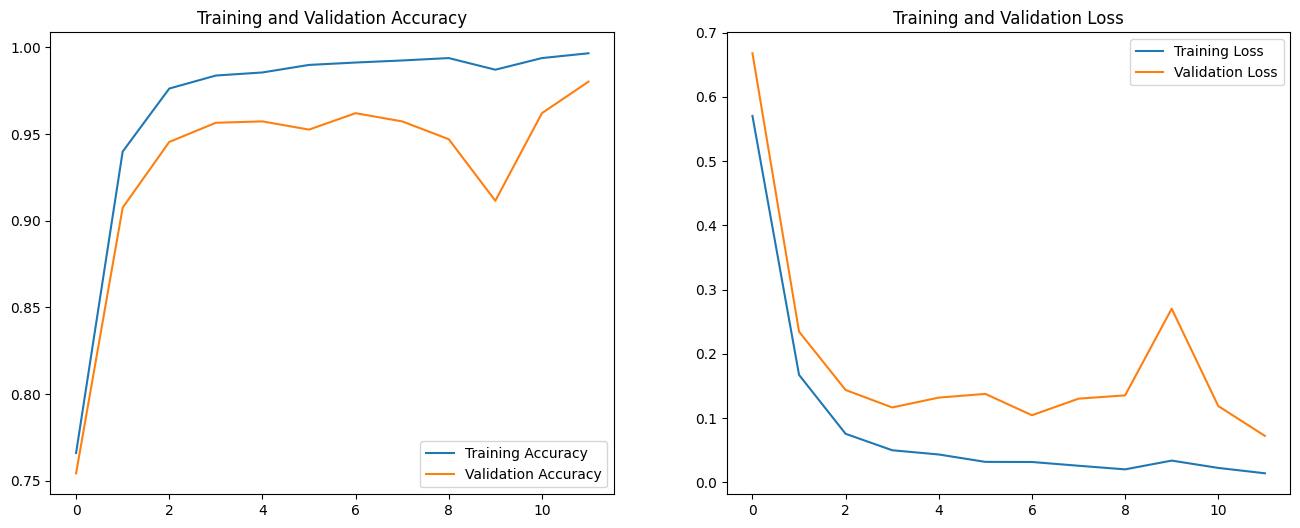

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Generate predicted probabilities from the model
predicted_probabilities = model.predict(x_val).ravel()  # Ensure it's a 1D array

# Prepare y_val as a binary 1D array if it's not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()

# Get predicted probabilities for the validation set
y_val_probs = model.predict(x_val)

# Assuming binary classification and using sigmoid output, you may want to flatten the probabilities if necessary
y_val_probs = y_val_probs.flatten()

40/40 [==============================] - 6s 141ms/step


Optimal threshold: 0.49
Optimal F1 Score:  0.9861431870669746


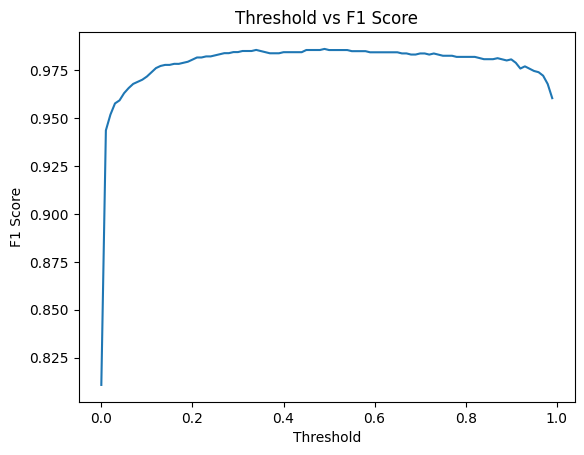

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predicted_probabilities' contains the predicted probabilities for the validation set

def calculate_f1_scores(probabilities, true_labels):
    """Calculates F1 scores for a range of thresholds."""
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(true_labels, (probabilities > threshold).astype(int)) for threshold in thresholds]
    return thresholds, f1_scores

def find_optimal_threshold(probabilities, true_labels):
    """Finds the threshold that yields the highest F1 score."""
    thresholds, f1_scores = calculate_f1_scores(probabilities, true_labels)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_scores[optimal_idx]  # Return the F1 score as well

# Example usage:

optimal_threshold, optimal_f1_score = find_optimal_threshold(predicted_probabilities, y_val)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal F1 Score:  {optimal_f1_score}")

# Plotting (unchanged from your original code)
thresholds, f1_scores = calculate_f1_scores(predicted_probabilities, y_val)
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.show()


40/40 [==============================] - 6s 144ms/step
Accuracy: 0.9802527646129542
Precision: 0.9827188940092166
Recall: 0.9884125144843569
Specificity: 0.9627791563275434
F1-score: 0.9855574812247256
ROC-AUC: 0.9966531431413874


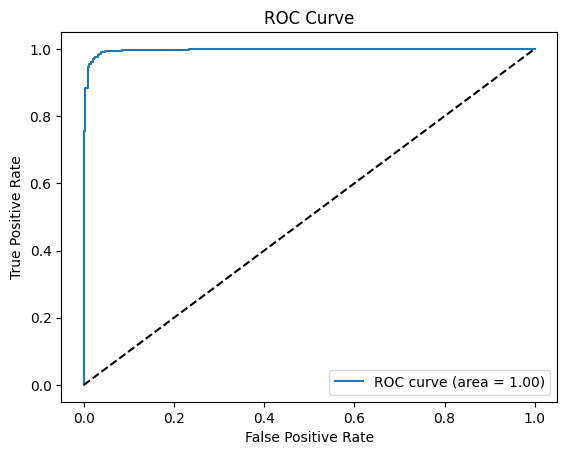

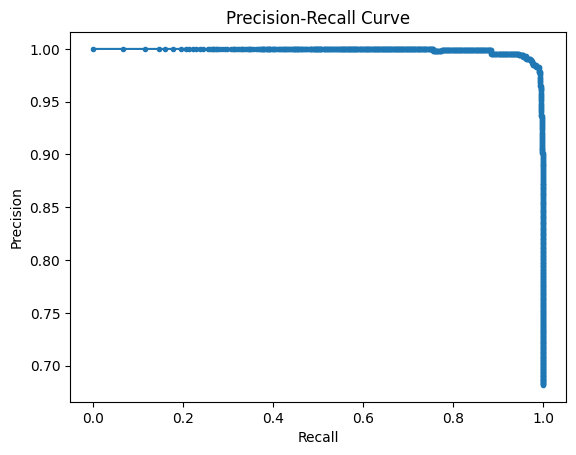

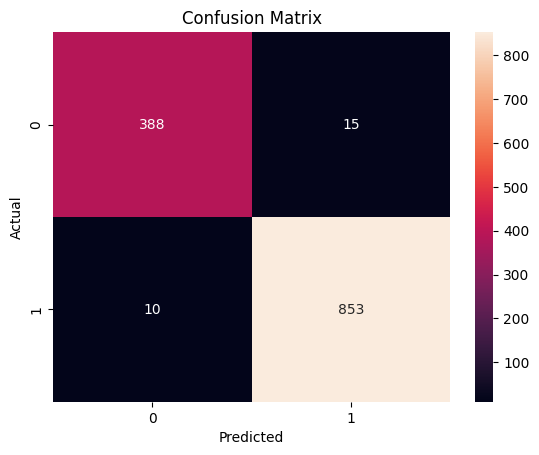

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf


# Generate predictions
y_pred_prob = model.predict(x_val)
y_pred = np.round(y_pred_prob)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn+fp)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss

# Convert binary predictions back to probabilities for class 1
y_pred_probs_binary = y_pred_binary * y_pred_probs + (1 - y_pred_binary) * (1 - y_pred_probs)

# Brier score
brier = brier_score_loss(Y_test, y_pred_probs_binary)
print(f'Brier Score: {brier:.4f}')

50/50 [==============================] - 12s 251ms/step
Brier Score: 0.3109


50/50 [==============================] - 7s 143ms/step
ECE: 0.0144
MCE: 0.4138


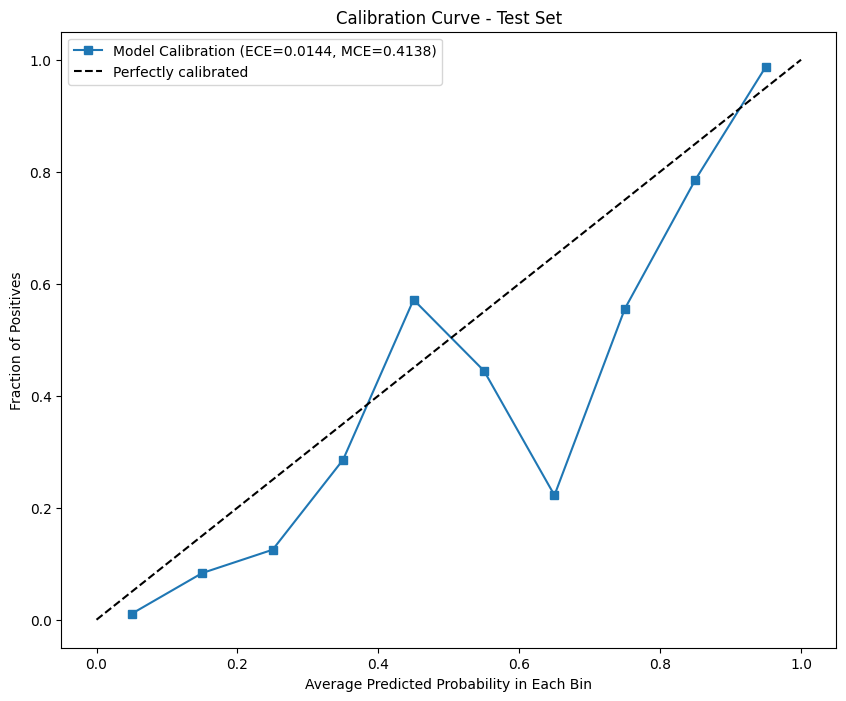

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.25).astype(int)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss

# Convert binary predictions back to probabilities for class 1
y_pred_probs_binary = y_pred_binary * y_pred_probs + (1 - y_pred_binary) * (1 - y_pred_probs)

# Brier score
brier = brier_score_loss(Y_test, y_pred_probs_binary)
print(f'Brier Score: {brier:.4f}')

# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.49).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test data
# Get predicted probabilities for the validation or test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities from your model

# Actual test labels should be in 'Y_test'
# Ensure these are 1D arrays
y_pred_probs = y_pred_probs.flatten()
Y_test = Y_test.flatten()

n_bins = 10
bin_width = 1.0 / n_bins
bin_edges = np.linspace(0, 1, n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_counts = np.histogram(y_pred_probs, bins=bin_edges)[0]
bin_correct = np.histogram(y_pred_probs[Y_test == 1], bins=bin_edges)[0]
bin_scores = np.histogram(y_pred_probs, bins=bin_edges, weights=y_pred_probs)[0]

# Avoid division by zero
bin_accuracies = np.where(bin_counts > 0, bin_correct / bin_counts, 0)
bin_confidences = np.where(bin_counts > 0, bin_scores / bin_counts, 0)

ece = np.sum((np.abs(bin_accuracies - bin_confidences) * bin_counts) / Y_test.size)
mce = np.max(np.abs(bin_accuracies - bin_confidences))

print(f'ECE: {ece:.4f}')
print(f'MCE: {mce:.4f}')

# Plot the calibration curve
# Calibration plot
plt.figure(figsize=(10, 8))
plt.plot(bin_centers, bin_accuracies, 's-', label=f'Model Calibration (ECE={ece:.4f}, MCE={mce:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.title('Calibration Curve - Test Set')
plt.xlabel('Average Predicted Probability in Each Bin')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()


In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.49).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

50/50 [==============================] - 7s 134ms/step
Log Loss: 0.0744


50/50 [==============================] - 7s 135ms/step
Original - Brier score loss: 0.0204, Log Loss: 0.0744
Platt - Brier score loss: 0.0226, Log Loss: 0.0968
Isotonic - Brier score loss: 0.0207, Log Loss: 0.0838


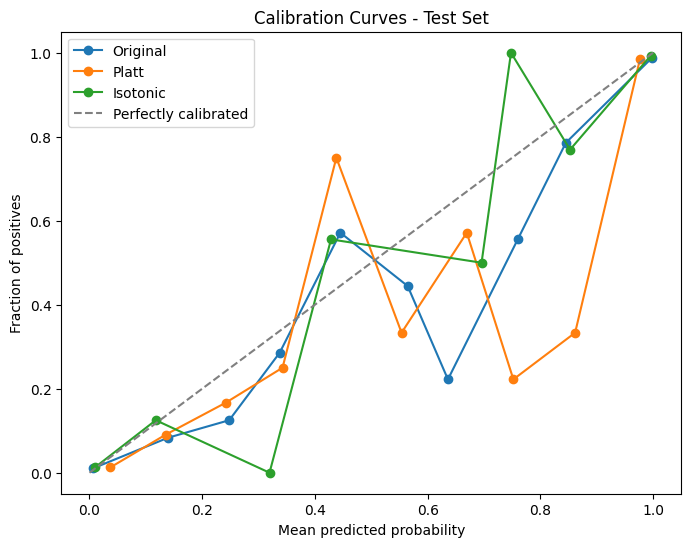

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate predicted probabilities for both validation and test sets
val_probs = model.predict(x_val).ravel()
test_probs = model.predict(X_test).ravel()

# Prepare binary arrays if not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()
y_test_binary = np.argmax(Y_test, axis=1) if Y_test.ndim > 1 else Y_test.flatten()

# Fit Platt Scaling on validation probabilities
platt_scaler = LogisticRegression(solver='liblinear')
platt_scaler.fit(val_probs.reshape(-1, 1), y_val_binary)

# Apply Platt scaling to test set probabilities
calibrated_probs_platt = platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1]

# Fit and apply Isotonic Regression for calibration on validation probabilities
isotonic_scaler = IsotonicRegression(out_of_bounds='clip')
isotonic_scaler.fit(val_probs, y_val_binary)

# Apply Isotonic Regression to test set probabilities
calibrated_probs_isotonic = isotonic_scaler.transform(test_probs)

# Calculate the original and calibrated Brier score loss and log loss for test set
metrics = {
    'Original': test_probs,
    'Platt': calibrated_probs_platt,
    'Isotonic': calibrated_probs_isotonic
}

for label, probs in metrics.items():
    brier = brier_score_loss(y_test_binary, probs)
    logloss = log_loss(y_test_binary, probs)
    print(f"{label} - Brier score loss: {brier:.4f}, Log Loss: {logloss:.4f}")

# Plot calibration curves for the test set
plt.figure(figsize=(8, 6))
for label, probs in metrics.items():
    prob_true, prob_pred = calibration_curve(y_test_binary, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=label)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves - Test Set')
plt.legend()
plt.show()


50/50 [==============================] - 7s 134ms/step


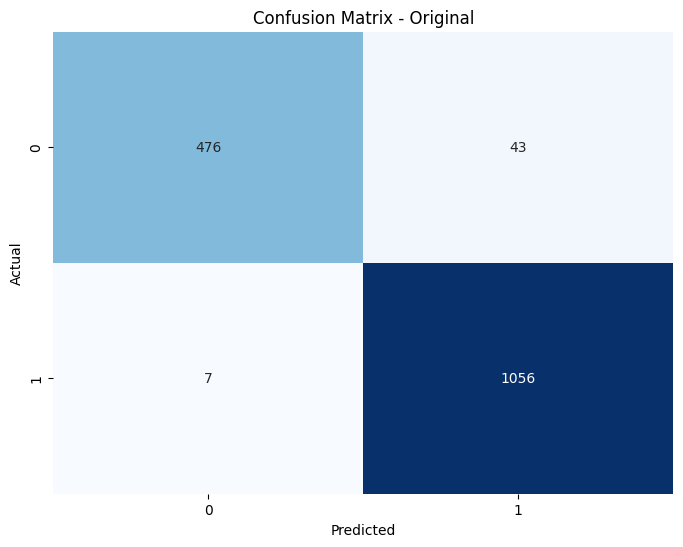

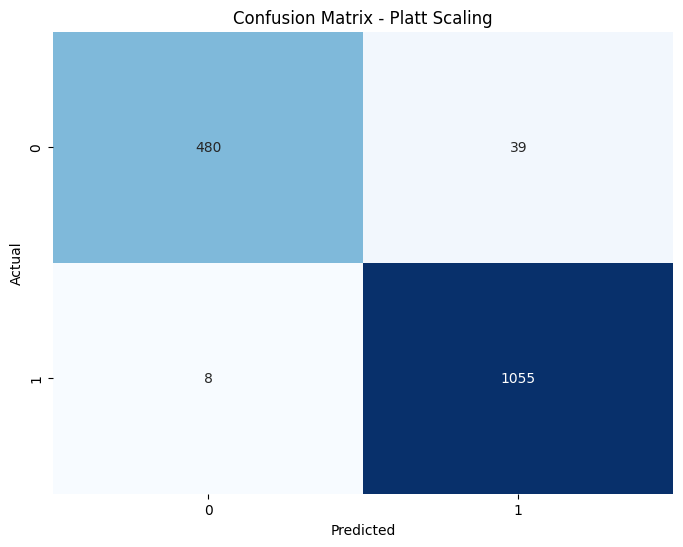

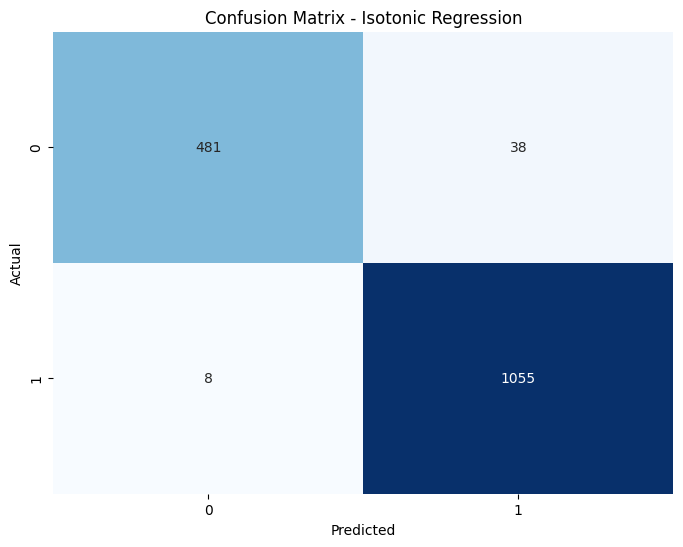

Classification Report - Original:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       519
           1       0.96      0.99      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.96      0.96      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Platt Scaling:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       519
           1       0.96      0.99      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.96      0.97      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Isotonic Regression:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       519
           1       0.97      0.99      0.98      1063

    accuracy                           0.97      1582
   macro a

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set using your trained model
predicted_probabilities_test = model.predict(X_test).ravel()

# Assuming you have already defined calibrated_probs_platt and calibrated_probs_isotonic using the test set probabilities
# If not, you would need to generate these using the calibration models trained on the validation set probabilities.

# Choose a threshold for classification
threshold = 0.25  # Adjust this threshold to suit your application

# Convert the calibrated probabilities to class predictions based on the chosen threshold
predicted_classes_original = (predicted_probabilities_test >= threshold).astype(int)
predicted_classes_platt = (calibrated_probs_platt >= threshold).astype(int)
predicted_classes_isotonic = (calibrated_probs_isotonic >= threshold).astype(int)

# Compute confusion matrices for the original and calibrated probabilities
cm_original = confusion_matrix(y_test_binary, predicted_classes_original)
cm_platt = confusion_matrix(y_test_binary, predicted_classes_platt)
cm_isotonic = confusion_matrix(y_test_binary, predicted_classes_isotonic)

# Define a function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot the confusion matrices
plot_confusion_matrix(cm_original, 'Confusion Matrix - Original')
plot_confusion_matrix(cm_platt, 'Confusion Matrix - Platt Scaling')
plot_confusion_matrix(cm_isotonic, 'Confusion Matrix - Isotonic Regression')

# Print out the classification report for each
print('Classification Report - Original:')
print(classification_report(y_test_binary, predicted_classes_original))

print('Classification Report - Platt Scaling:')
print(classification_report(y_test_binary, predicted_classes_platt))

print('Classification Report - Isotonic Regression:')
print(classification_report(y_test_binary, predicted_classes_isotonic))


**FINAL EXPERIMENT**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import os
import pickle

# Define normalize_staining and preprocess_image functions

def normalize_staining(img):
    """
    Normalize the staining of histopathology images to reduce variations.
    """
    # Convert to float and divide by 255
    img = img.astype(np.float32) / 255

    # Define stain vectors (from Ruifrok AC and Johnston DA)
    # Hematoxylin + Eosin
    H = np.array([0.65, 0.70, 0.29])
    E = np.array([0.07, 0.99, 0.11])
    # Create orthogonal matrix
    HE = np.array([H, E]).T

    # Perform color deconvolution
    Y = np.linalg.solve(HE, img.reshape(-1, 3).T).T

    # Normalize stains to 0-1 range
    Y = (Y - np.min(Y, axis=0)) / (np.max(Y, axis=0) - np.min(Y, axis=0))

    # Recreate the image using only the Hematoxylin channel
    recreated_img = np.clip(Y[:, 0] * H, 0, 1)
    recreated_img = (recreated_img.reshape(img.shape[0], img.shape[1], 3) * 255).astype(np.uint8)

    return recreated_img

def preprocess_image(img):
    # Resize the image to square dimensions (e.g., 224x224)
    resized_img = cv2.resize(img, (224, 224))
    # Normalize the staining (assuming this is your normalization function)
    normalized_img = normalize_staining(resized_img)

    # Apply CLAHE
    img_lab = cv2.cvtColor(normalized_img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    return img_clahe

# Custom weighted binary cross-entropy function
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    # Explicitly cast y_true to float
    y_true_float = tf.cast(y_true, tf.float32)

    # Calculate binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)

    # Calculate the weight vector
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative

    # Apply weights to the binary crossentropy
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

# Build model function with binary classification adjustments
def build_model():
    model = Sequential()
    backbone = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.add(backbone)
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

    return model



# Train the model without dynamic alpha
def train_model(model_function, train_dataset, val_dataset, epochs, model_save_dir, class_weights):
    model = model_function()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: weighted_binary_crossentropy(
                      y_true, y_pred,
                      weight_positive=class_weights[1],
                      weight_negative=class_weights[0]),
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)

    # Data augmentation generator with preprocessing function
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
)
    history = model.fit(
        train_dataset[0], train_dataset[1],
        epochs=epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=[early_stop, rlrp]
    )

    # Save model and training history
    model_path = os.path.join(model_save_dir, "dense_clahe2.h5")
    model.save(model_path)
    history_path = os.path.join(model_save_dir, "dense_clahe2_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model and training history saved to {model_save_dir}")

    return model, history

# Prepare datasets for training
# Assuming x_train, y_train, x_val, y_val are defined and preprocessed

# Class weights for imbalanced data
total_samples = len(y_train)
class_counts = np.unique(y_train, return_counts=True)[1]
weight_for_0 = total_samples / (2 * class_counts[0])
weight_for_1 = total_samples / (2 * class_counts[1])
class_weights = {0: weight_for_0, 1: weight_for_1}

# Train the model without dynamic alpha
model_save_dir = "/content/drive/MyDrive/KaggleData/Predictions"
model, history = train_model(build_model, (x_train, y_train), (x_val, y_val), 12, model_save_dir, class_weights)

# Now you can safely evaluate the model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')





Epoch 1/12
159/159 [==============================] - 188s 587ms/step - loss: 0.4465 - accuracy: 0.8342 - val_loss: 0.5356 - val_accuracy: 0.7978 - lr: 1.0000e-04
Epoch 2/12
159/159 [==============================] - 90s 565ms/step - loss: 0.1451 - accuracy: 0.9490 - val_loss: 0.1690 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 3/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0649 - accuracy: 0.9781 - val_loss: 0.1390 - val_accuracy: 0.9550 - lr: 1.0000e-04
Epoch 4/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0494 - accuracy: 0.9844 - val_loss: 0.1419 - val_accuracy: 0.9581 - lr: 1.0000e-04
Epoch 5/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0358 - accuracy: 0.9905 - val_loss: 0.1239 - val_accuracy: 0.9613 - lr: 1.0000e-04
Epoch 6/12
159/159 [==============================] - 90s 564ms/step - loss: 0.0237 - accuracy: 0.9937 - val_loss: 0.1503 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 7/12
159/159 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and training history saved to /content/drive/MyDrive/KaggleData/Predictions
40/40 [==============================] - 6s 140ms/step - loss: 0.0865 - accuracy: 0.9700
Validation Loss: 0.08646588027477264, Validation Accuracy: 0.9699841737747192


In [ ]:
# Save model and training history
model_path = os.path.join(model_save_dir, "dense_clahe2.h5")  # Add the custom name here
model.save(model_path)

history_path = os.path.join(model_save_dir, "dense_clahe2_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"Dynamic custom model and training history saved to {model_save_dir}")


Dynamic custom model and training history saved to /content/drive/MyDrive/KaggleData/Predictions


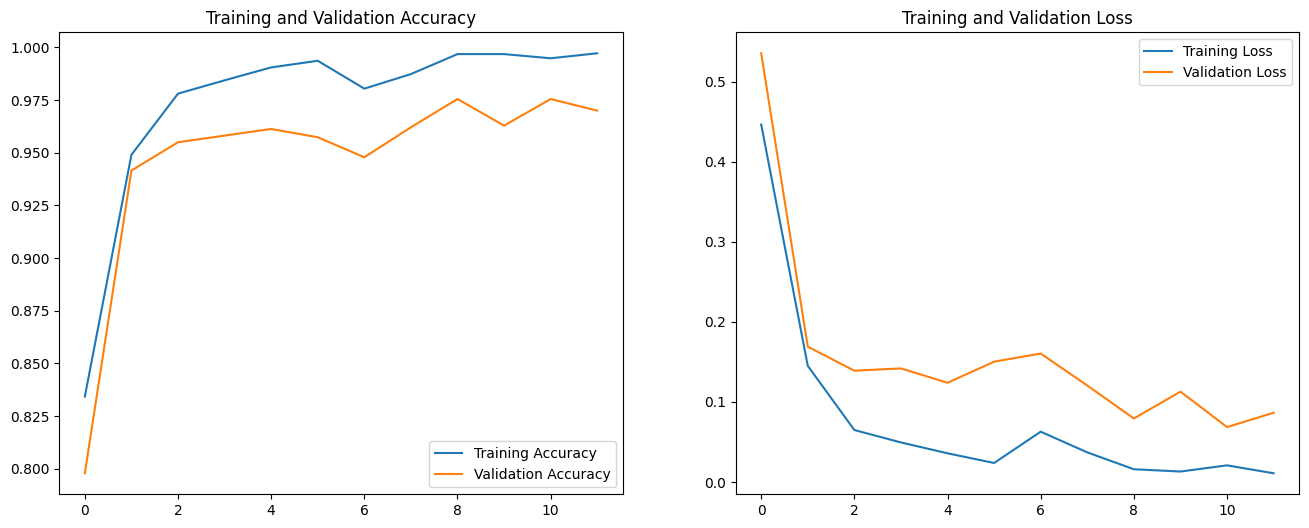

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Generate predicted probabilities from the model
predicted_probabilities = model.predict(x_val).ravel()  # Ensure it's a 1D array

# Prepare y_val as a binary 1D array if it's not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()

# Get predicted probabilities for the validation set
y_val_probs = model.predict(x_val)

# Assuming binary classification and using sigmoid output, you may want to flatten the probabilities if necessary
y_val_probs = y_val_probs.flatten()

40/40 [==============================] - 5s 138ms/step


Optimal threshold: 0.43
Optimal F1 Score:  0.9786003470213998


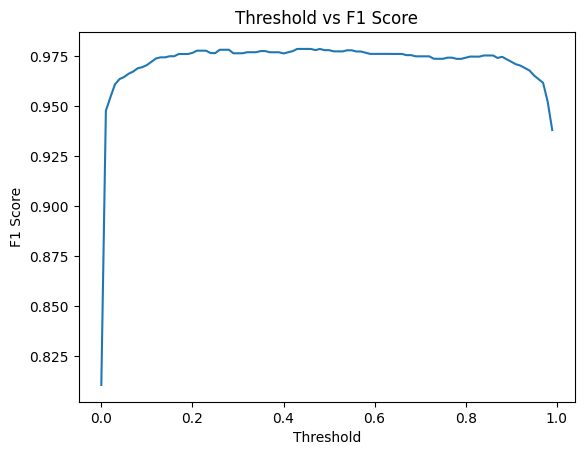

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predicted_probabilities' contains the predicted probabilities for the validation set

def calculate_f1_scores(probabilities, true_labels):
    """Calculates F1 scores for a range of thresholds."""
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(true_labels, (probabilities > threshold).astype(int)) for threshold in thresholds]
    return thresholds, f1_scores

def find_optimal_threshold(probabilities, true_labels):
    """Finds the threshold that yields the highest F1 score."""
    thresholds, f1_scores = calculate_f1_scores(probabilities, true_labels)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_scores[optimal_idx]  # Return the F1 score as well

# Example usage:

optimal_threshold, optimal_f1_score = find_optimal_threshold(predicted_probabilities, y_val)
print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal F1 Score:  {optimal_f1_score}")

# Plotting (unchanged from your original code)
thresholds, f1_scores = calculate_f1_scores(predicted_probabilities, y_val)
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.show()

40/40 [==============================] - 5s 138ms/step
Accuracy: 0.9699842022116903
Precision: 0.9779837775202781
Recall: 0.9779837775202781
Specificity: 0.9528535980148883
F1-score: 0.9779837775202781
ROC-AUC: 0.9950659739094682


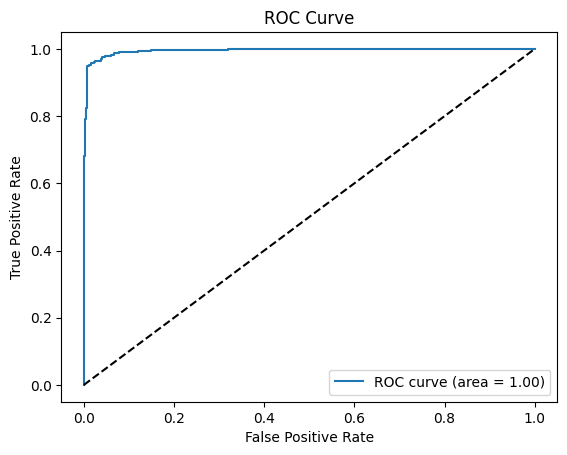

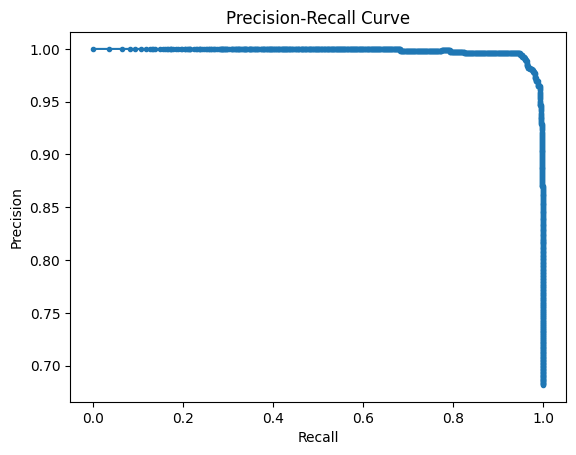

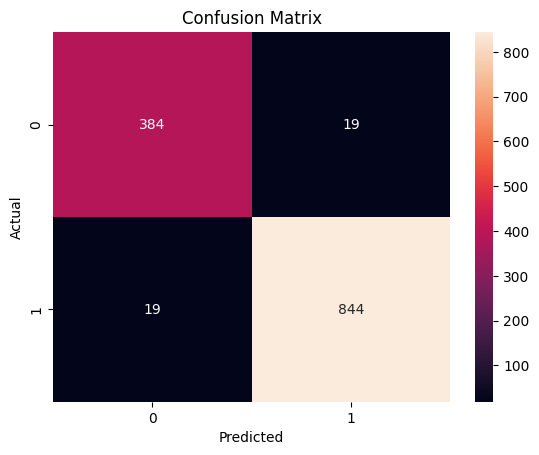

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf


# Generate predictions
y_pred_prob = model.predict(x_val)
y_pred = np.round(y_pred_prob)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn+fp)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.25).astype(int)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss

# Convert binary predictions back to probabilities for class 1
y_pred_probs_binary = y_pred_binary * y_pred_probs + (1 - y_pred_binary) * (1 - y_pred_probs)

# Brier score
brier = brier_score_loss(Y_test, y_pred_probs_binary)
print(f'Brier Score: {brier:.4f}')

50/50 [==============================] - 7s 139ms/step
Brier Score: 0.3151


In [ ]:


# Assuming 'model' is your trained model and 'X_test' is your test data.
y_pred_probs = model.predict(X_test).ravel()  # Get predicted probabilities

# Convert probabilities to binary predictions based on a threshold, usually 0.5 for binary classification
y_pred_binary = (y_pred_probs > 0.49).astype(int)

from sklearn.metrics import log_loss

# Log loss
logloss = log_loss(Y_test, y_pred_probs)  # Note that we use the predicted probabilities here, not the binary predictions.

print(f'Log Loss: {logloss:.4f}')

50/50 [==============================] - 7s 140ms/step
Log Loss: 0.0845


50/50 [==============================] - 7s 141ms/step
ECE: 0.0142
MCE: 0.3865


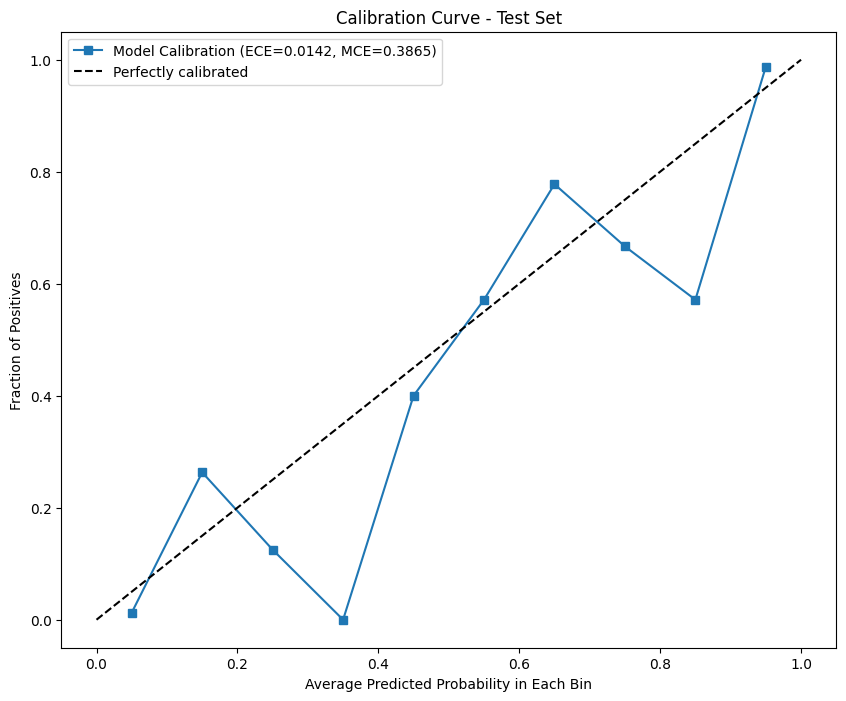

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test data
# Get predicted probabilities for the validation or test set
y_pred_probs = model.predict(X_test)  # Get predicted probabilities from your model

# Actual test labels should be in 'Y_test'
# Ensure these are 1D arrays
y_pred_probs = y_pred_probs.flatten()
Y_test = Y_test.flatten()

n_bins = 10
bin_width = 1.0 / n_bins
bin_edges = np.linspace(0, 1, n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_counts = np.histogram(y_pred_probs, bins=bin_edges)[0]
bin_correct = np.histogram(y_pred_probs[Y_test == 1], bins=bin_edges)[0]
bin_scores = np.histogram(y_pred_probs, bins=bin_edges, weights=y_pred_probs)[0]

# Avoid division by zero
bin_accuracies = np.where(bin_counts > 0, bin_correct / bin_counts, 0)
bin_confidences = np.where(bin_counts > 0, bin_scores / bin_counts, 0)

ece = np.sum((np.abs(bin_accuracies - bin_confidences) * bin_counts) / Y_test.size)
mce = np.max(np.abs(bin_accuracies - bin_confidences))

print(f'ECE: {ece:.4f}')
print(f'MCE: {mce:.4f}')

# Plot the calibration curve
# Calibration plot
plt.figure(figsize=(10, 8))
plt.plot(bin_centers, bin_accuracies, 's-', label=f'Model Calibration (ECE={ece:.4f}, MCE={mce:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.title('Calibration Curve - Test Set')
plt.xlabel('Average Predicted Probability in Each Bin')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

50/50 [==============================] - 7s 139ms/step
Original - Brier score loss: 0.0214, Log Loss: 0.0845
Platt - Brier score loss: 0.0229, Log Loss: 0.1026
Isotonic - Brier score loss: 0.0212, Log Loss: 0.0797


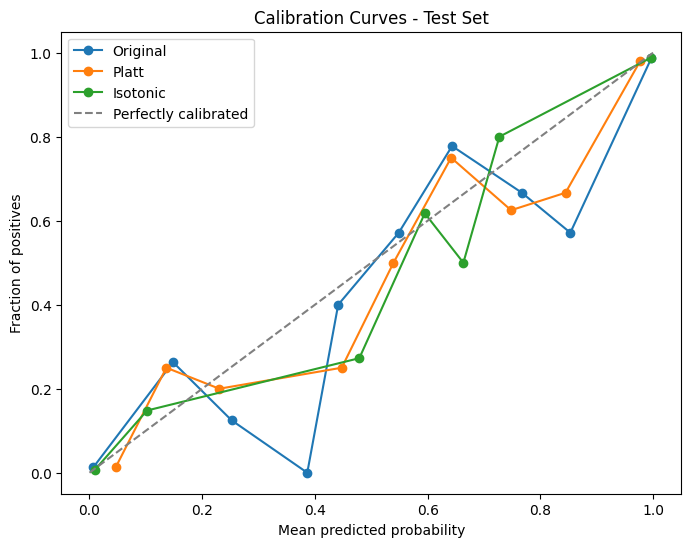

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate predicted probabilities for both validation and test sets
val_probs = model.predict(x_val).ravel()
test_probs = model.predict(X_test).ravel()

# Prepare binary arrays if not already
y_val_binary = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val.flatten()
y_test_binary = np.argmax(Y_test, axis=1) if Y_test.ndim > 1 else Y_test.flatten()

# Fit Platt Scaling on validation probabilities
platt_scaler = LogisticRegression(solver='liblinear')
platt_scaler.fit(val_probs.reshape(-1, 1), y_val_binary)

# Apply Platt scaling to test set probabilities
calibrated_probs_platt = platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1]

# Fit and apply Isotonic Regression for calibration on validation probabilities
isotonic_scaler = IsotonicRegression(out_of_bounds='clip')
isotonic_scaler.fit(val_probs, y_val_binary)

# Apply Isotonic Regression to test set probabilities
calibrated_probs_isotonic = isotonic_scaler.transform(test_probs)

# Calculate the original and calibrated Brier score loss and log loss for test set
metrics = {
    'Original': test_probs,
    'Platt': calibrated_probs_platt,
    'Isotonic': calibrated_probs_isotonic
}

for label, probs in metrics.items():
    brier = brier_score_loss(y_test_binary, probs)
    logloss = log_loss(y_test_binary, probs)
    print(f"{label} - Brier score loss: {brier:.4f}, Log Loss: {logloss:.4f}")

# Plot calibration curves for the test set
plt.figure(figsize=(8, 6))
for label, probs in metrics.items():
    prob_true, prob_pred = calibration_curve(y_test_binary, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=label)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves - Test Set')
plt.legend()
plt.show()

50/50 [==============================] - 7s 139ms/step


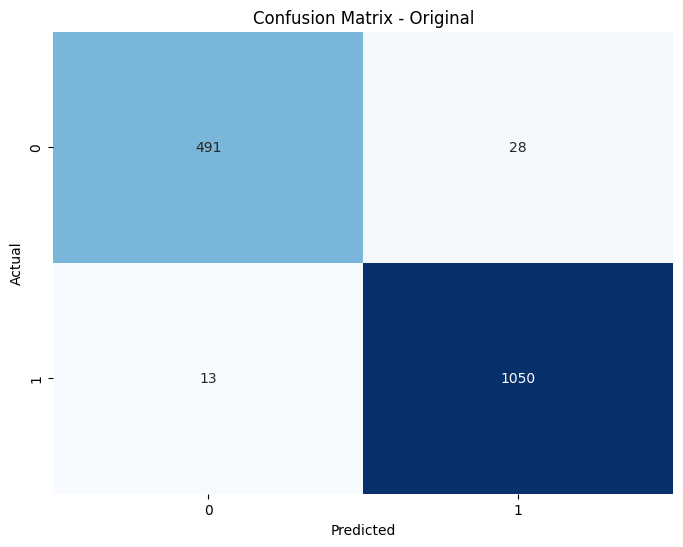

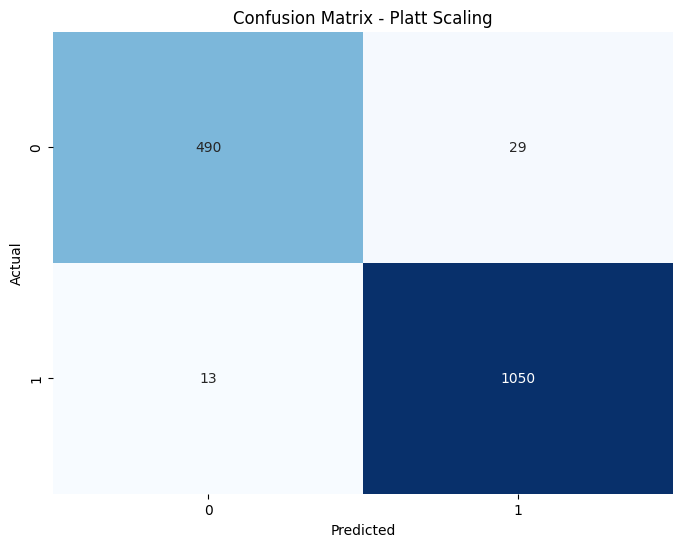

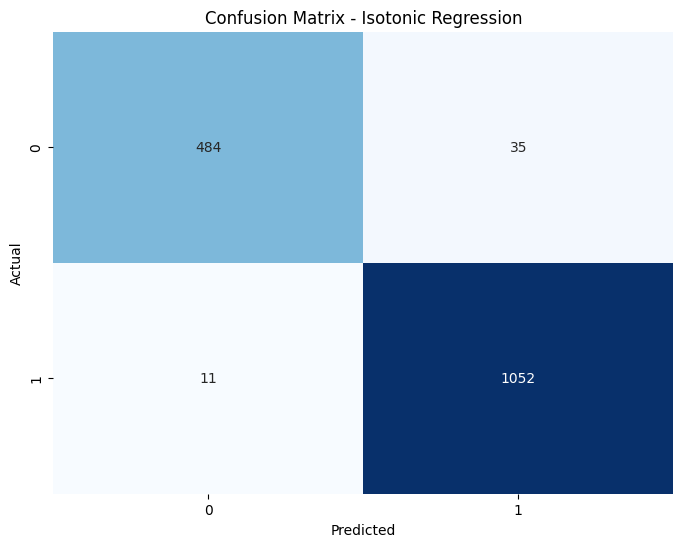

Classification Report - Original:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       519
           1       0.97      0.99      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.97      0.97      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Platt Scaling:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       519
           1       0.97      0.99      0.98      1063

    accuracy                           0.97      1582
   macro avg       0.97      0.97      0.97      1582
weighted avg       0.97      0.97      0.97      1582

Classification Report - Isotonic Regression:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       519
           1       0.97      0.99      0.98      1063

    accuracy                           0.97      1582
   macro a

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set using your trained model
predicted_probabilities_test = model.predict(X_test).ravel()

# Assuming you have already defined calibrated_probs_platt and calibrated_probs_isotonic using the test set probabilities
# If not, you would need to generate these using the calibration models trained on the validation set probabilities.

# Choose a threshold for classification
threshold = 0.43  # Adjust this threshold to suit your application

# Convert the calibrated probabilities to class predictions based on the chosen threshold
predicted_classes_original = (predicted_probabilities_test >= threshold).astype(int)
predicted_classes_platt = (calibrated_probs_platt >= threshold).astype(int)
predicted_classes_isotonic = (calibrated_probs_isotonic >= threshold).astype(int)

# Compute confusion matrices for the original and calibrated probabilities
cm_original = confusion_matrix(y_test_binary, predicted_classes_original)
cm_platt = confusion_matrix(y_test_binary, predicted_classes_platt)
cm_isotonic = confusion_matrix(y_test_binary, predicted_classes_isotonic)

# Define a function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot the confusion matrices
plot_confusion_matrix(cm_original, 'Confusion Matrix - Original')
plot_confusion_matrix(cm_platt, 'Confusion Matrix - Platt Scaling')
plot_confusion_matrix(cm_isotonic, 'Confusion Matrix - Isotonic Regression')

# Print out the classification report for each
print('Classification Report - Original:')
print(classification_report(y_test_binary, predicted_classes_original))

print('Classification Report - Platt Scaling:')
print(classification_report(y_test_binary, predicted_classes_platt))

print('Classification Report - Isotonic Regression:')
print(classification_report(y_test_binary, predicted_classes_isotonic))